Data sourcing

In [581]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [611]:
# import data
df = pd.read_csv('loan.csv')

C:\Users\khang\AppData\Local\Temp\ipykernel_4468\2768520423.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


Data cleaning

In [583]:
# preivew data
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39713,90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39714,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39715,90376,89243,5000,5000,650.0,36 months,7.43%,155.38,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [584]:
#checking the count of NaN values in column 
df.iloc[:,:].isna().sum() 

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [585]:
# remove columns contain 90% NaN values
df.dropna(axis=1, thresh=len(df)*0.9, inplace=True)

In [586]:
# review data for further cleaning
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


In [587]:
# drop columns contain 90% of repeated values
df.drop(columns=df.columns[df.eq(0).mean()>0.89], inplace=True)
df.drop(columns=df.columns[df.eq(1).mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('f').mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('n').mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('INDIVIDUAL').mean()>0.90], inplace=True)

# drop loan status current row values since this variable is not relevant to the analysis
df.drop(df[df['loan_status'] == 'Current'].index, inplace=True)

In [588]:
# reivew data after cleaning
df.head(100).style

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,purpose,title,zip_code,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d
0,1077501,1296599,5000,5000,4975.000000,36 months,10.65%,162.870000,B,B2,nan,10+ years,RENT,24000.000000,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,credit_card,Computer,860xx,AZ,27.650000,Jan-85,1,3,13648,83.70%,9,5863.155187,5833.840000,5000.000000,863.160000,Jan-15,171.620000,May-16
1,1077430,1314167,2500,2500,2500.000000,60 months,15.27%,59.830000,C,C4,Ryder,< 1 year,RENT,30000.000000,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,car,bike,309xx,GA,1.000000,Apr-99,5,3,1687,9.40%,4,1008.710000,1008.710000,456.460000,435.170000,Apr-13,119.660000,Sep-13
2,1077175,1313524,2400,2400,2400.000000,36 months,15.96%,84.330000,C,C5,nan,10+ years,RENT,12252.000000,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,small_business,real estate business,606xx,IL,8.720000,Nov-01,2,2,2956,98.50%,10,3005.666844,3005.670000,2400.000000,605.670000,Jun-14,649.910000,May-16
3,1076863,1277178,10000,10000,10000.000000,36 months,13.49%,339.310000,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.000000,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1076863,other,personel,917xx,CA,20.000000,Feb-96,1,10,5598,21%,37,12231.890000,12231.890000,10000.000000,2214.920000,Jan-15,357.480000,Apr-16
5,1075269,1311441,5000,5000,5000.000000,36 months,7.90%,156.460000,A,A4,Veolia Transportaton,3 years,RENT,36000.000000,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1075269,wedding,My wedding loan I promise to pay back,852xx,AZ,11.200000,Nov-04,3,9,7963,28.30%,12,5632.210000,5632.210000,5000.000000,632.210000,Jan-15,161.030000,Jan-16
6,1069639,1304742,7000,7000,7000.000000,60 months,15.96%,170.080000,C,C5,Southern Star Photography,8 years,RENT,47004.000000,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1069639,debt_consolidation,Loan,280xx,NC,23.510000,Jul-05,1,7,17726,85.60%,11,10110.840000,10110.840000,6985.610000,3125.230000,May-16,1313.760000,May-16
7,1072053,1288686,3000,3000,3000.000000,36 months,18.64%,109.430000,E,E1,MKC Accounting,9 years,RENT,48000.000000,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1072053,car,Car Downpayment,900xx,CA,5.350000,Jan-07,2,4,8221,87.50%,4,3939.135294,3939.140000,3000.000000,939.140000,Jan-15,111.340000,Dec-14
8,1071795,1306957,5600,5600,5600.000000,60 months,21.28%,152.390000,F,F2,nan,4 years,OWN,40000.000000,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=1071795,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.550000,Apr-04,2,11,5210,32.60%,13,646.020000,646.020000,162.020000,294.940000,Apr-12,152.390000,Aug-12
9,1071570,1306721,5375,5375,5350.000000,60 months,12.69%,121.450000,B,B5,Starbucks,< 1 year,RENT,15000.000000,Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=1071570,other,Building my credit history.,774xx,TX,18.080000,Sep-04,0,2,9279,36.50%,3,1476.190000,1469.340000,673.480000,533.420000,Nov-12,121.450000,Mar-13
10,1070078,1305201,6500,6500,6500.000000,60 months,14.65%,153.450000,C,C3,Southwest Rural metro,5 years,OWN,72000.000000,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1070078,debt_consolidation,High intrest Consolidation,853xx,AZ,16.120000,Jan-98,2,14,4032,20.60%,23,7678.017673,7678.020000,6500.000000,1178.020000,Jun-13,1655.540000,Dec-15


Prepare Data for analysis

In [589]:
# review current columns
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_d',
       'last_pymnt_amnt', 'last_credit_pull_d'],
      dtype='object')

In [590]:
# pick relevant columns
picked_cols = ['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 
               'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 
               'verification_status', 'loan_status', 'purpose', 'addr_state', 
               'dti', 'revol_util']

# categorize column data type
cat_cols = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state','emp_length'] #categorical data type
num_cols = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_util'] #numeric data type


fix mixed type numeric data type column

In [591]:

# check numeric data type
check_type = pd.Series({df[x].name: df[x].dtype for x in num_cols})
print(check_type)

# check values in mixed data type column
print(df[[x for x in num_cols if df[x].dtype == object]].head())

# fix mixed data type column value
for col in num_cols:
    if df[col].dtype == object:
        df[col] = df[col].replace('%','',regex=True)
        df[col] = df[col].astype(float)

# review changes
print(check_type)


funded_amnt      int64
int_rate        object
installment    float64
annual_inc     float64
dti            float64
revol_util      object
dtype: object
  int_rate revol_util
0   10.65%     83.70%
1   15.27%      9.40%
2   15.96%     98.50%
3   13.49%        21%
5    7.90%     28.30%
funded_amnt      int64
int_rate        object
installment    float64
annual_inc     float64
dti            float64
revol_util      object
dtype: object


In [592]:
# create new column for numeric defaulters
df.loc[df['loan_status'] == 'Charged Off','default_rates'] = 1
df.loc[df['loan_status'] != 'Charged Off','default_rates'] = 0

# create an all_count column for count reference
df['all_count'] = 1

univariate analysis

In [593]:
# ignore futurewarning from Seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [594]:
# create plot funtion with data segment argument vs defaulters in sorted order
def defaulters_bar_plot(col_, df_):
    if df_.groupby(col_)[col_].count().index.size<=10:
        sns.barplot(x=col_, y='default_rates', data=df_.sort_values(col_))
    else:
        sns.barplot(x='default_rates', y=col_, data=df_)
    plt.xlabel(col_, fontsize=20)
    plt.ylabel('default_rates',fontsize=20)
    plt.yticks(fontsize='x-large')
    plt.xticks(fontsize='x-large')  
    plt.show()

# set global figsize
plt.rcParams['figure.figsize'] = (16, 9)
    

,count
term,
36 months,29096
60 months,9481


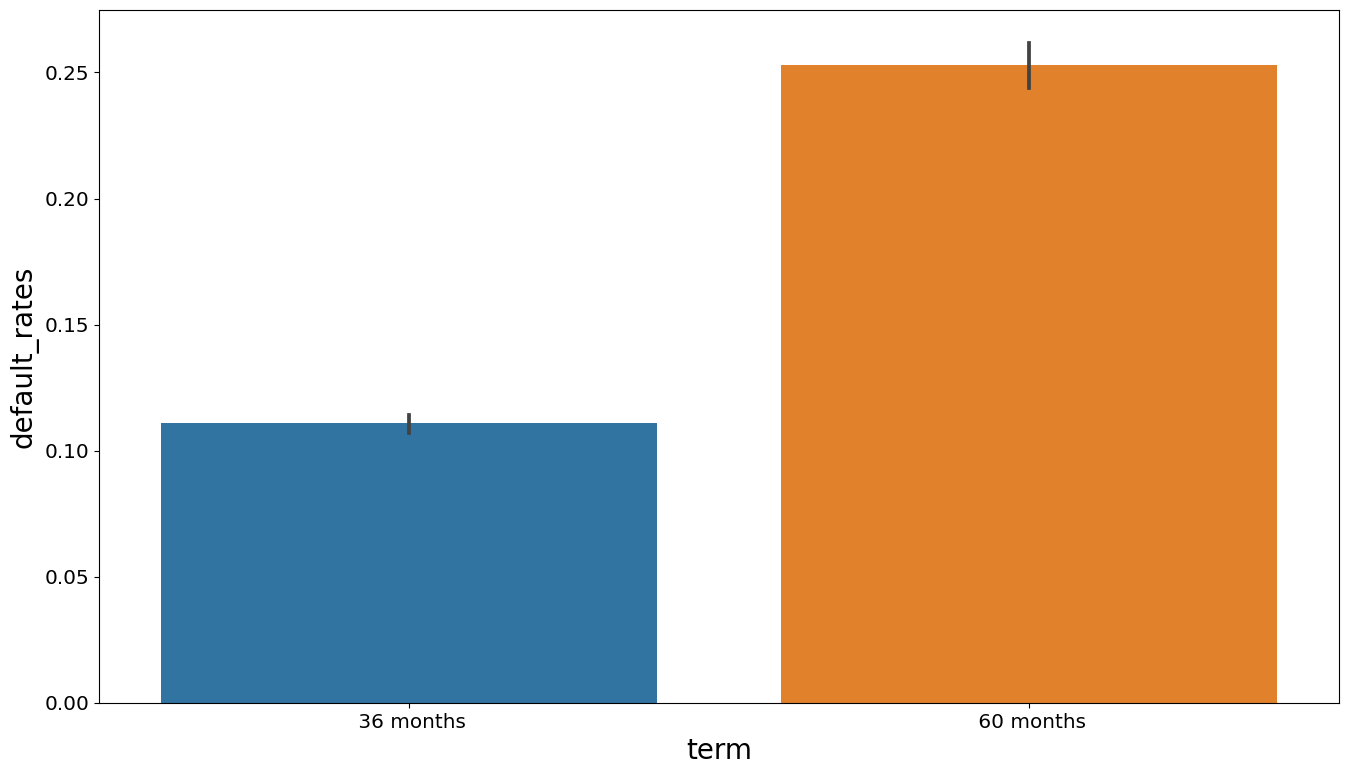

,count
grade,
B,11675
A,10045
C,7834
D,5085
E,2663
F,976
G,299


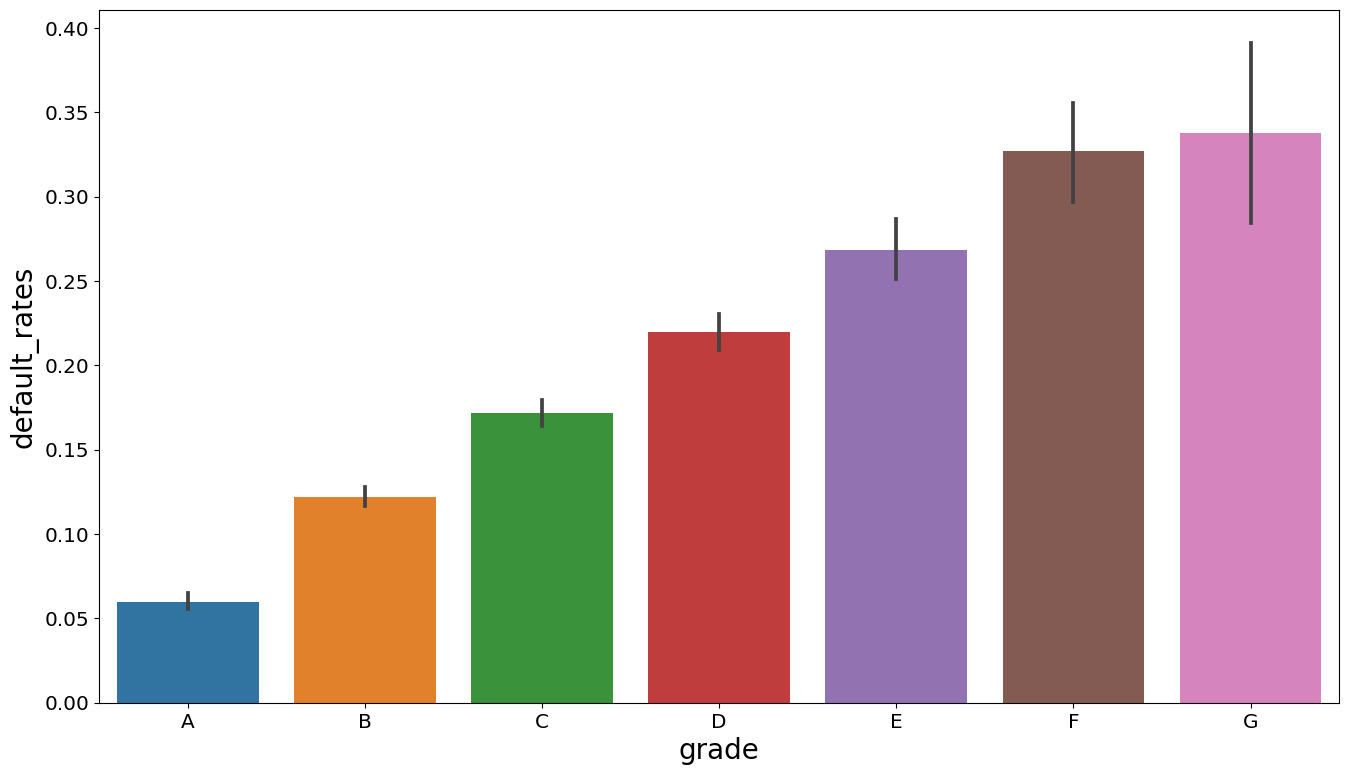

,count
sub_grade,
A4,2873
B3,2825
A5,2715
B5,2615
B4,2437
C1,2055
B2,2001
C2,1931
A3,1810


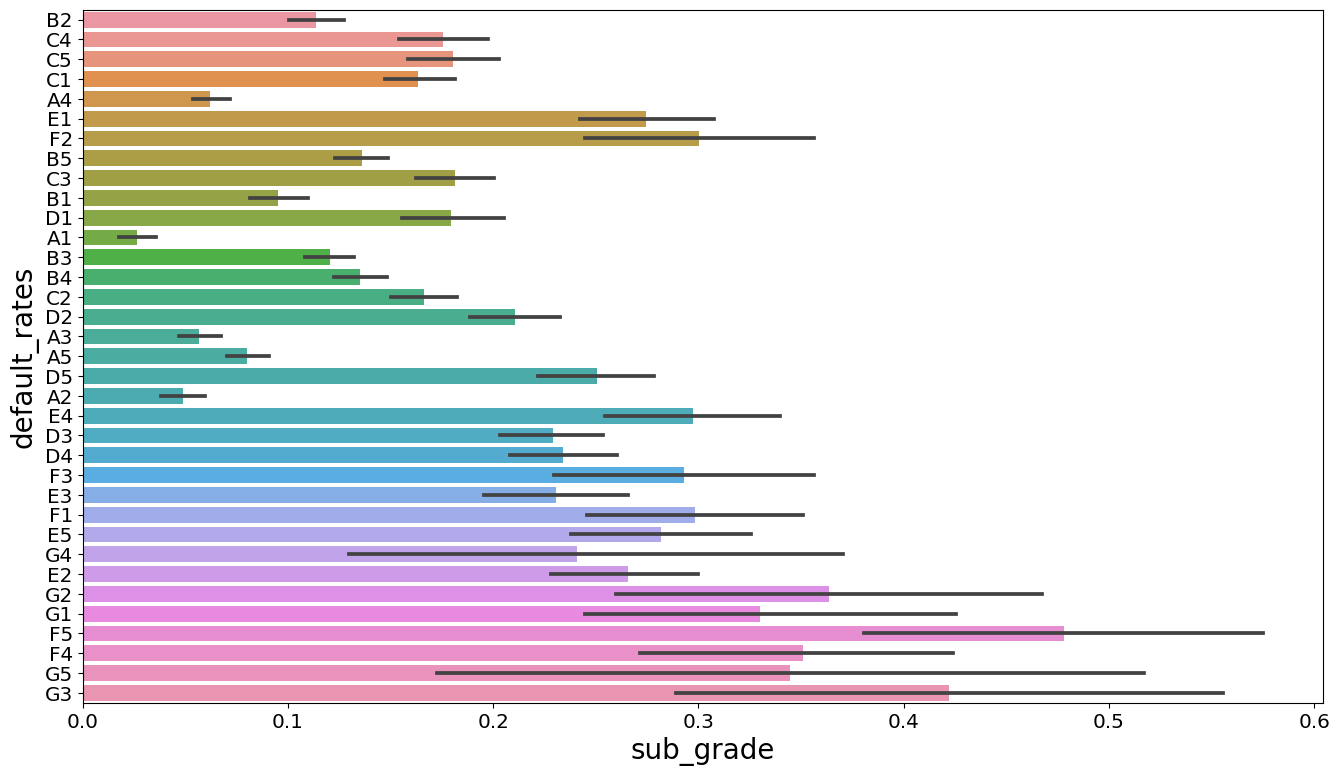

,count
home_ownership,
RENT,18480
MORTGAGE,17021
OWN,2975
OTHER,98
NONE,3


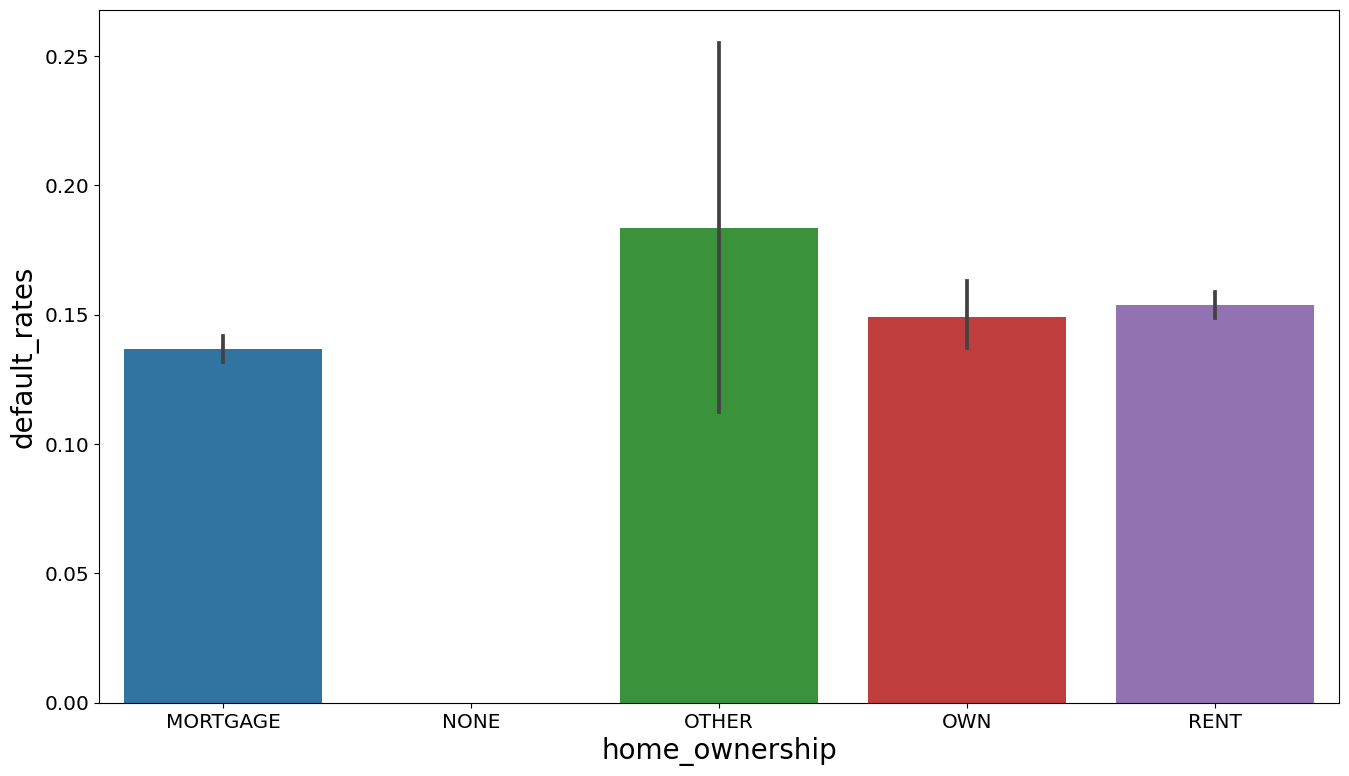

,count
verification_status,
Not Verified,16694
Verified,12206
Source Verified,9677


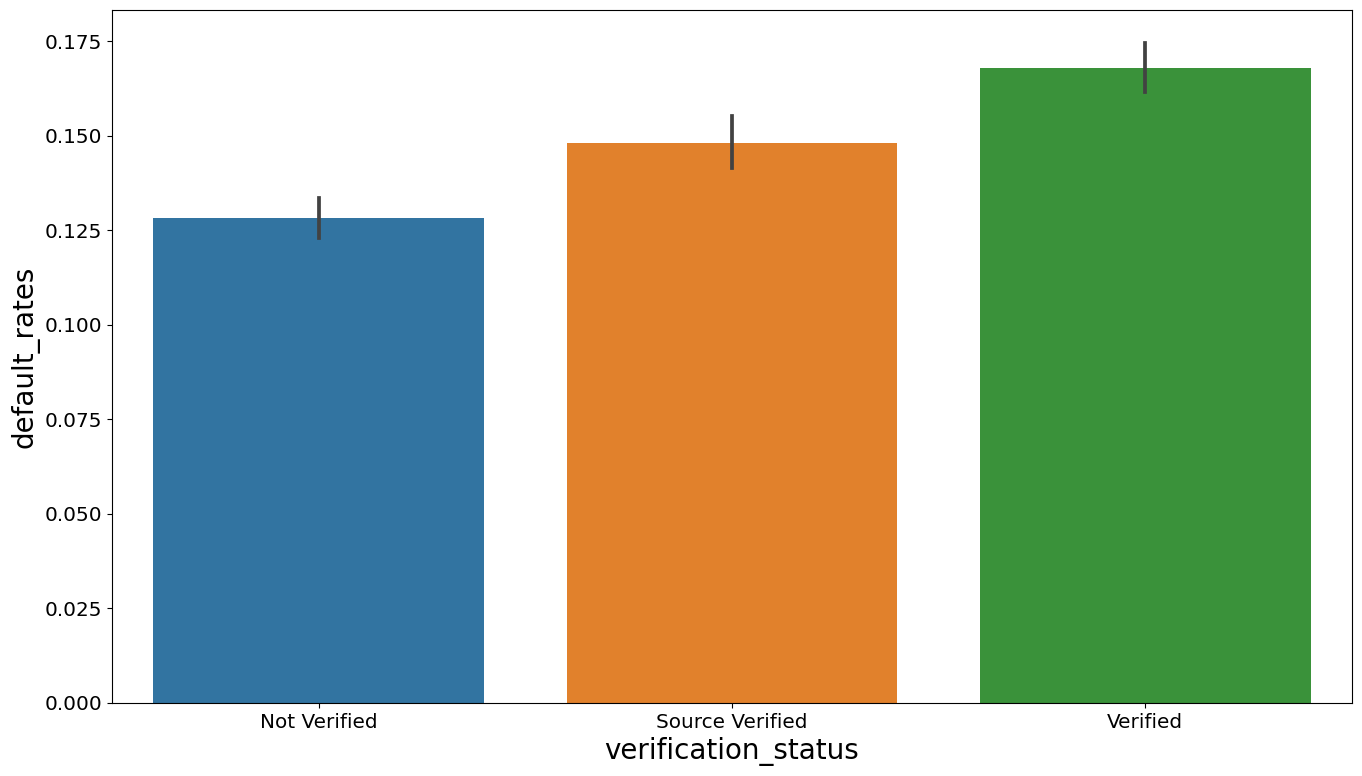

,count
purpose,
debt_consolidation,18055
credit_card,5027
other,3865
home_improvement,2875
major_purchase,2150
small_business,1754
car,1499
wedding,926
medical,681


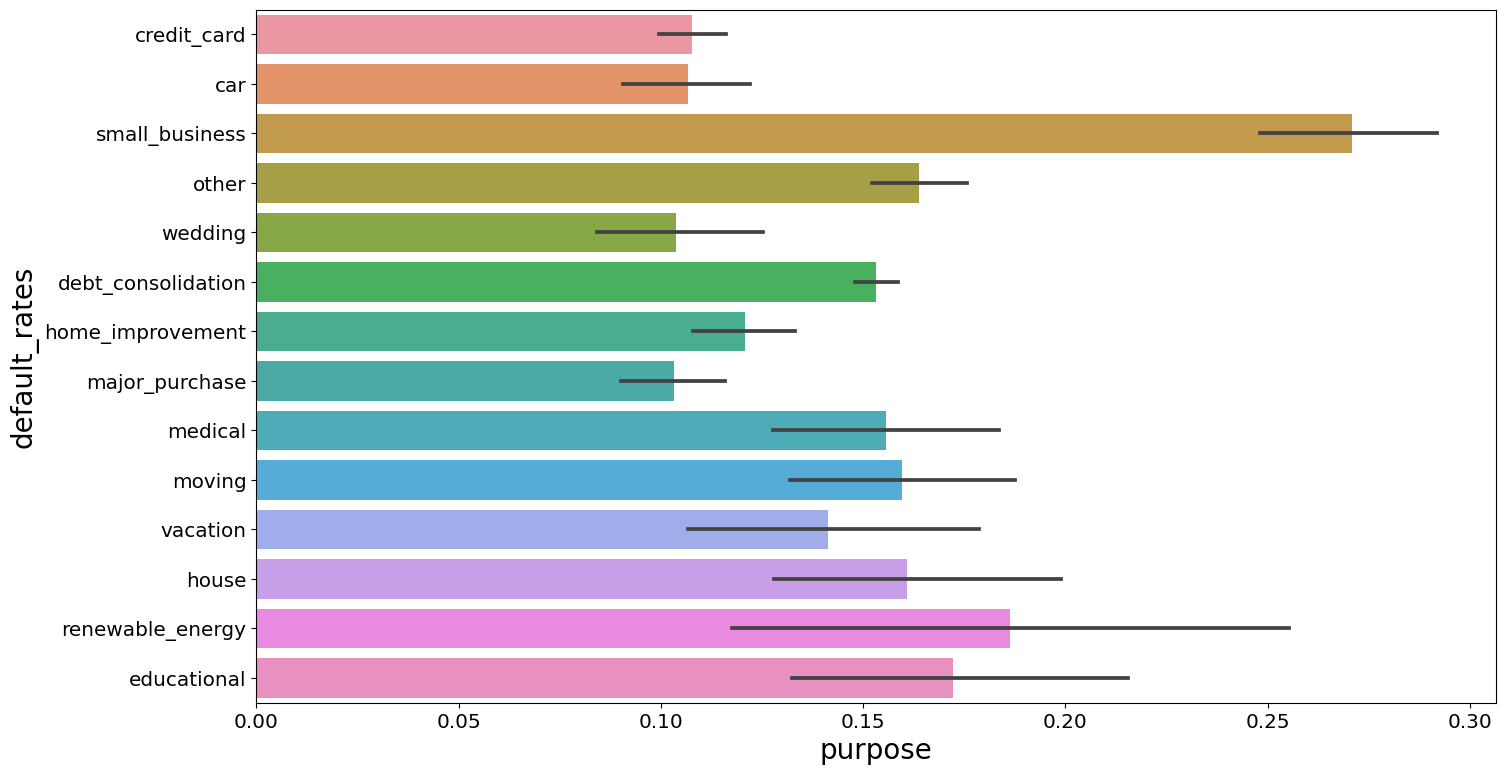

,count
addr_state,
CA,6949
NY,3698
FL,2781
TX,2659
NJ,1790
IL,1478
PA,1468
VA,1369
GA,1359


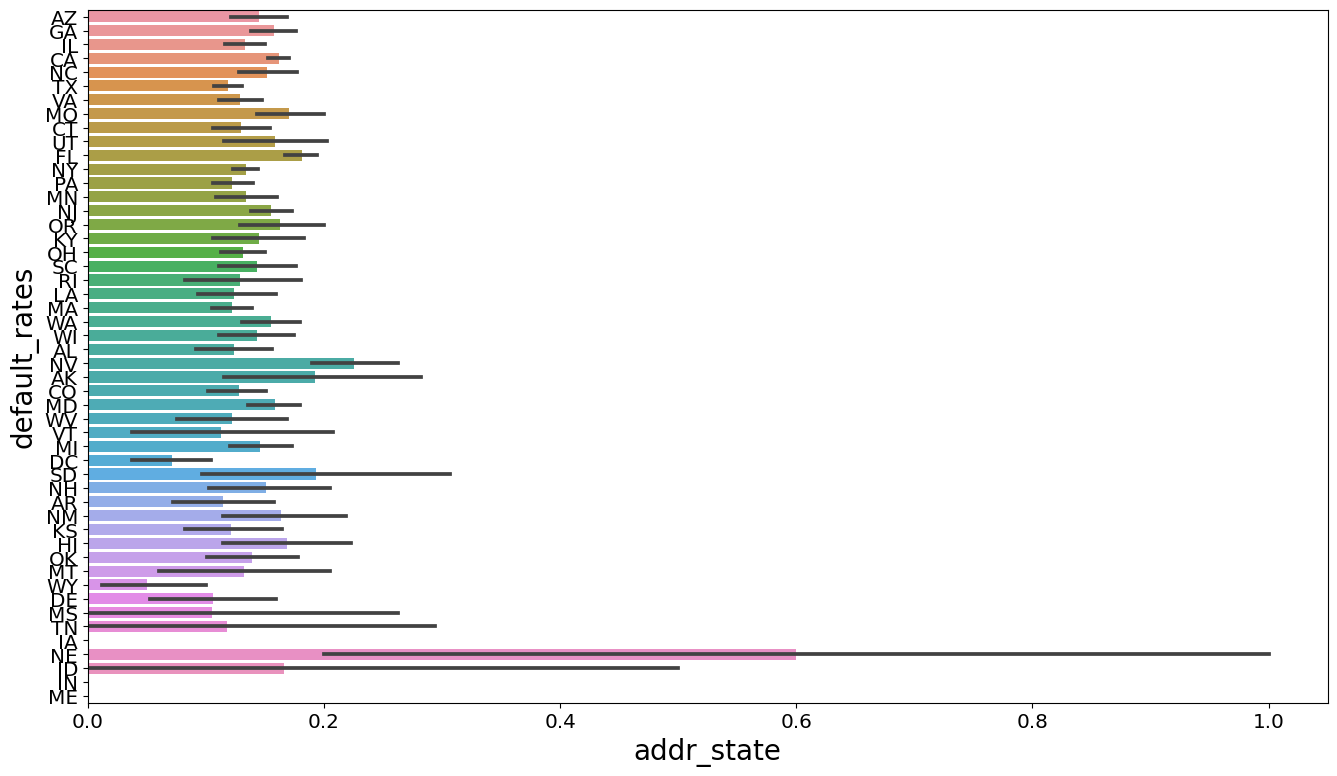

,count
emp_length,
10+ years,8488
< 1 year,4508
2 years,4291
3 years,4012
4 years,3342
5 years,3194
1 year,3169
6 years,2168
7 years,1711


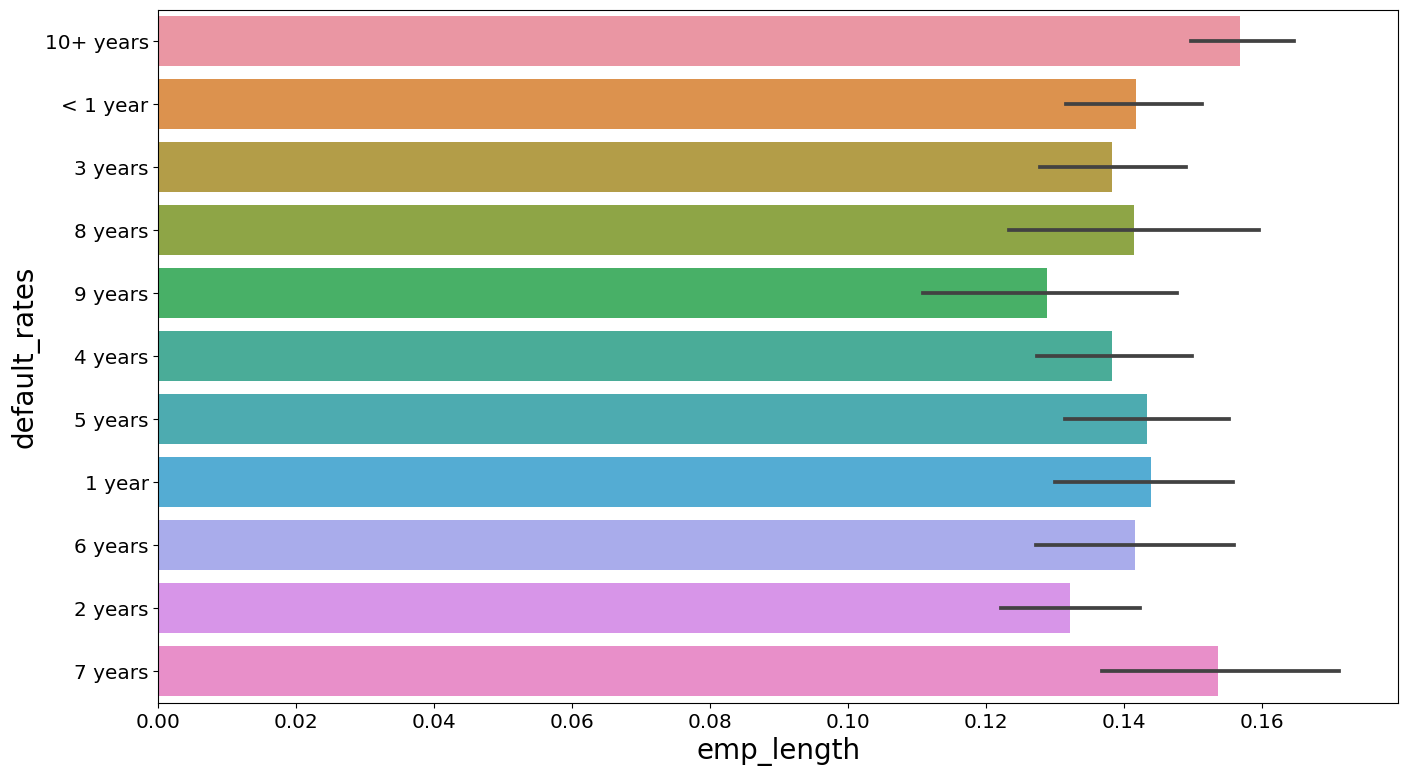

In [595]:
# gemerate plots for categorical data
for col_ in cat_cols:
    display(pd.DataFrame(df[col_].value_counts()))
    defaulters_bar_plot(col_, df)

list of sub categorical data that have the most defaulters ratio in its own segnment

In [596]:
# define pivot table initialization function
def create_pivot(col_):
    pivottable_ = pd.pivot_table(df, columns=['loan_status'], index=[col_], values=['all_count'], aggfunc='sum')
    pivottable_ = pivottable_.droplevel(0, axis=1)
    pivottable_['total_count'] = pivottable_['Charged Off'] + pivottable_['Fully Paid']
    pivottable_['default rates'] = pivottable_['Charged Off']/pivottable_['total_count']*100
    pivottable_.reset_index(inplace=True)
    pivottable_ = pivottable_.rename_axis(None, axis=1)   
    pivottable_.drop(index=pivottable_[pivottable_['total_count']<10].index, inplace=True)
    pivottable_.fillna(0, inplace=True)    
    return pivottable_

In [597]:
# define function
def defaulters_pivot_top_cat (list_cols):

# initialize variables
    new_df = pd.DataFrame()

    # anlysis
    for col_ in list_cols:
        pivottable_ = create_pivot(col_)
        name = f'df_{col_}'    
        pivottable_.iloc[:,0] = f'{col_}' + ' - ' + pivottable_.iloc[:,0] 
        pivottable_.rename(columns={col_: 'category'}, inplace=True)
        new_df = pd.concat([new_df, pivottable_], axis=0)
    new_df.sort_values(by='default rates', ascending=False, inplace=True)
    return new_df

In [598]:
# display top sub category
defaulters_pivot_top_cat(cat_cols).head(20).style.hide()

category,Charged Off,Fully Paid,total_count,default rates
sub_grade - F5,54.000000,59.000000,113.000000,47.787611
sub_grade - G3,19.000000,26.000000,45.000000,42.222222
sub_grade - G2,28.000000,49.000000,77.000000,36.363636
sub_grade - F4,53.000000,98.000000,151.000000,35.099338
sub_grade - G5,10.000000,19.000000,29.000000,34.482759
grade - G,101.000000,198.000000,299.000000,33.779264
sub_grade - G1,31.000000,63.000000,94.000000,32.978723
grade - F,319.000000,657.000000,976.000000,32.684426
sub_grade - F2,70.000000,163.000000,233.000000,30.042918
sub_grade - F1,91.000000,214.000000,305.000000,29.836066


Yashasvi please explain the graphs above in this markdown

Univariate Numeric Data

funded_amnt     618
int_rate        332
installment    4317
annual_inc     1253
dti            2219
revol_util      999
dtype: int64


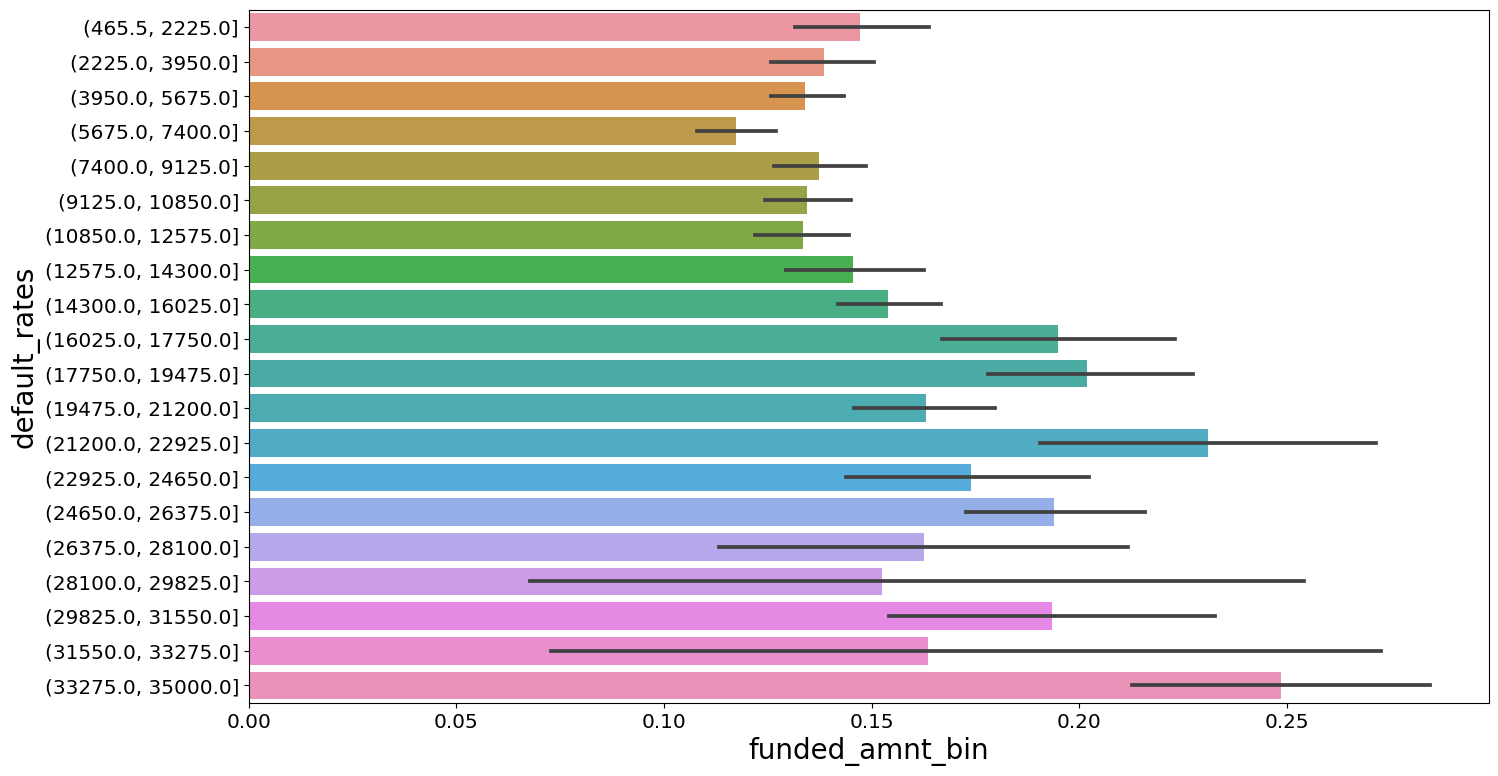

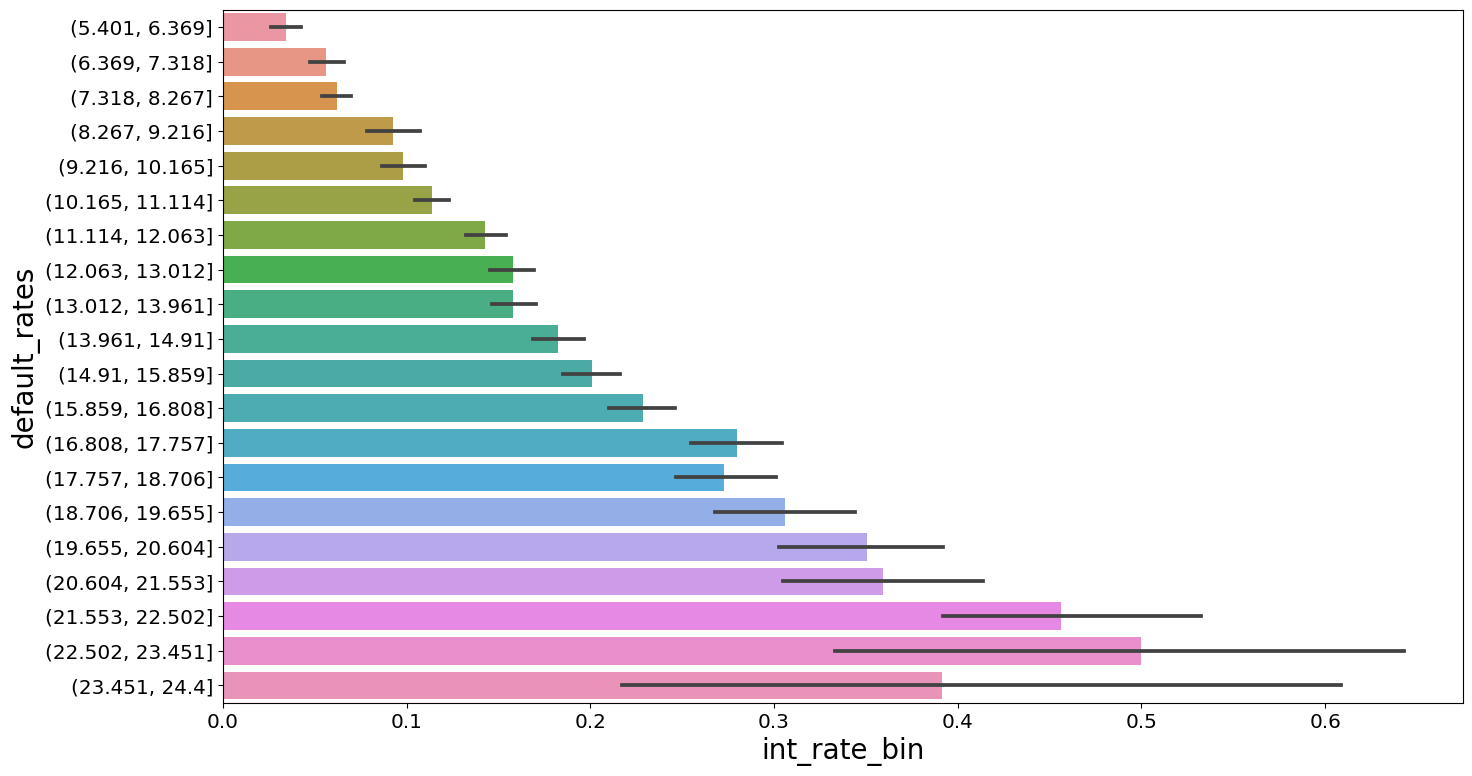

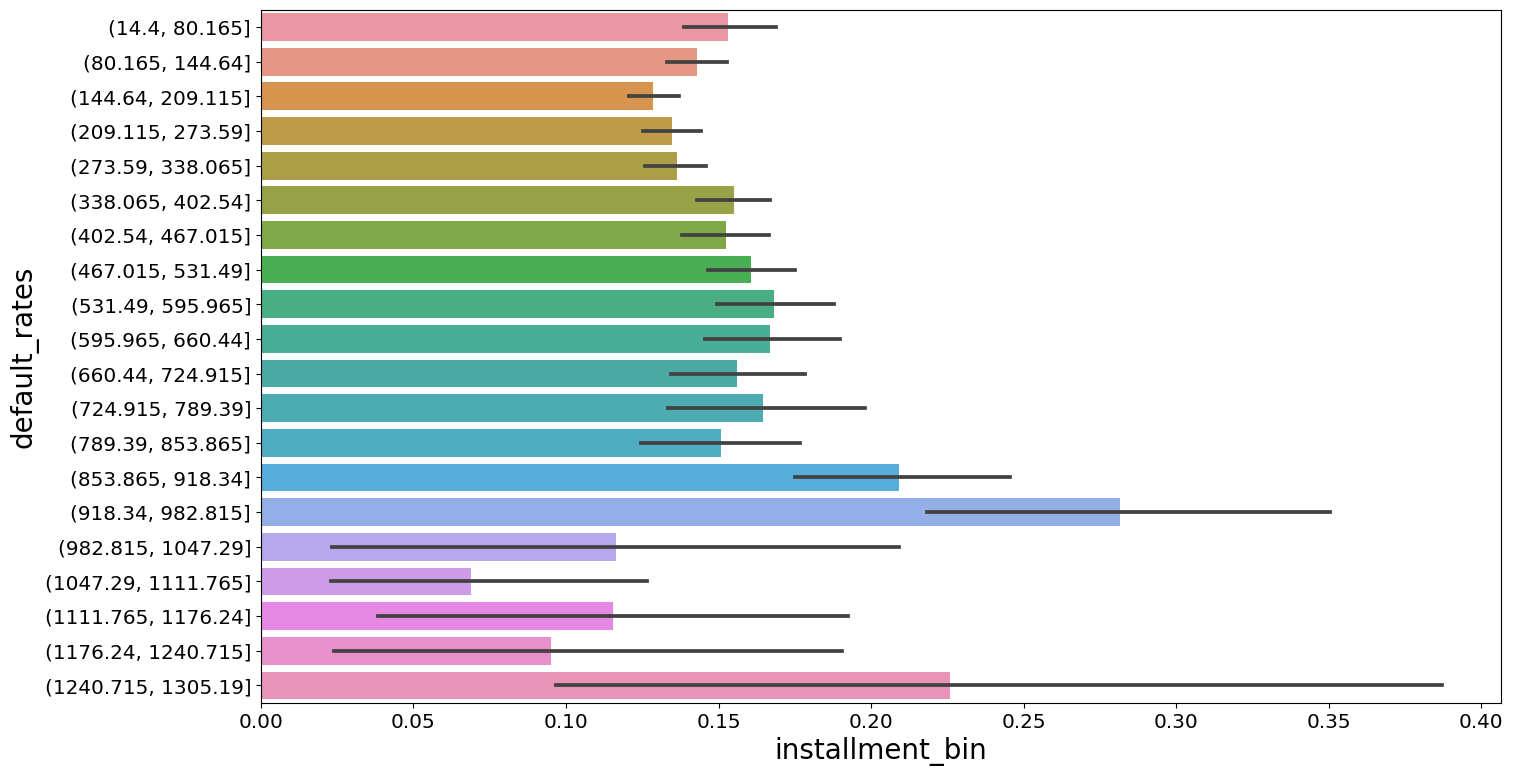

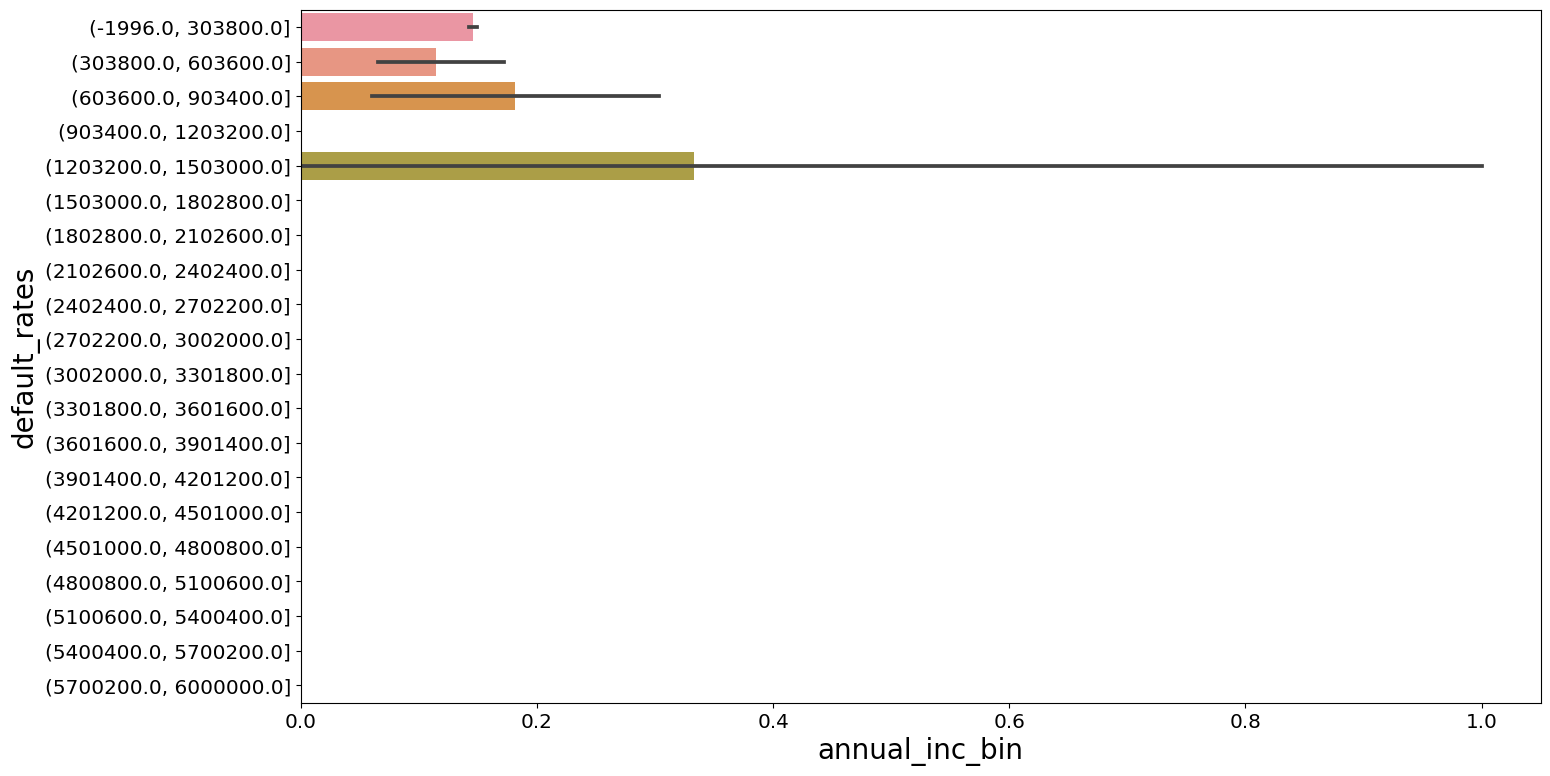

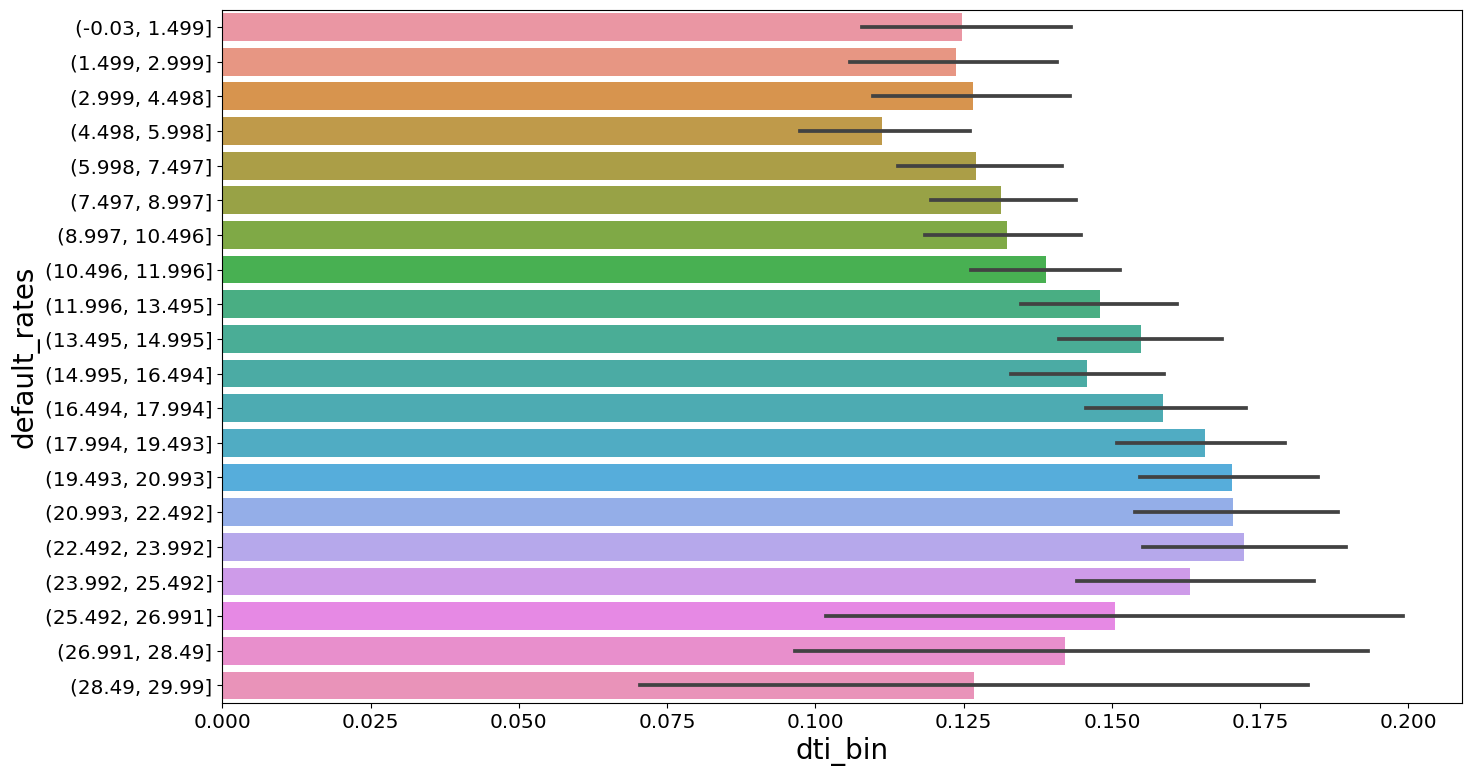

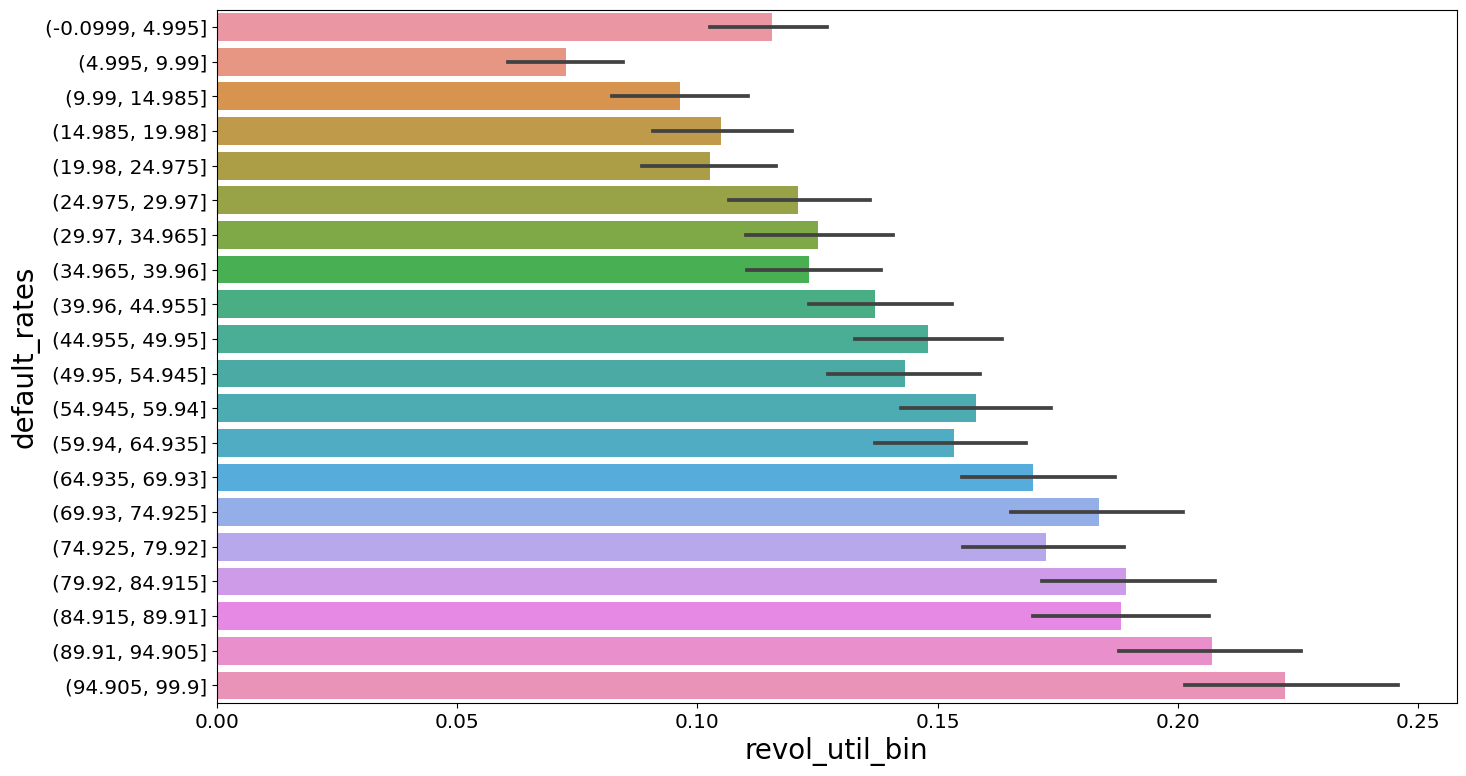

In [599]:
# count unique values of each numerical column data
defaulters_df = df[df['default_rates']==1]
count_unique = pd.Series({defaulters_df[x].name: defaulters_df[x].nunique() for x in num_cols})
print(count_unique)

# identify outliers
for col_ in num_cols:
    name = f'{col_}_bin'
    df[name] = pd.cut(np.array(df[col_]), bins=20)
    defaulters_bar_plot(name,df)

new_annual_inc_bin,values_count
"(2564.0, 75800.0]",27117
"(75800.0, 147600.0]",9725
"(147600.0, 219400.0]",1261
"(219400.0, 291200.0]",254
"(291200.0, 363000.0]",108
"(363000.0, 434800.0]",30
"(434800.0, 506600.0]",17
"(506600.0, 578400.0]",13
"(578400.0, 650200.0]",10
"(650200.0, 722000.0]",8


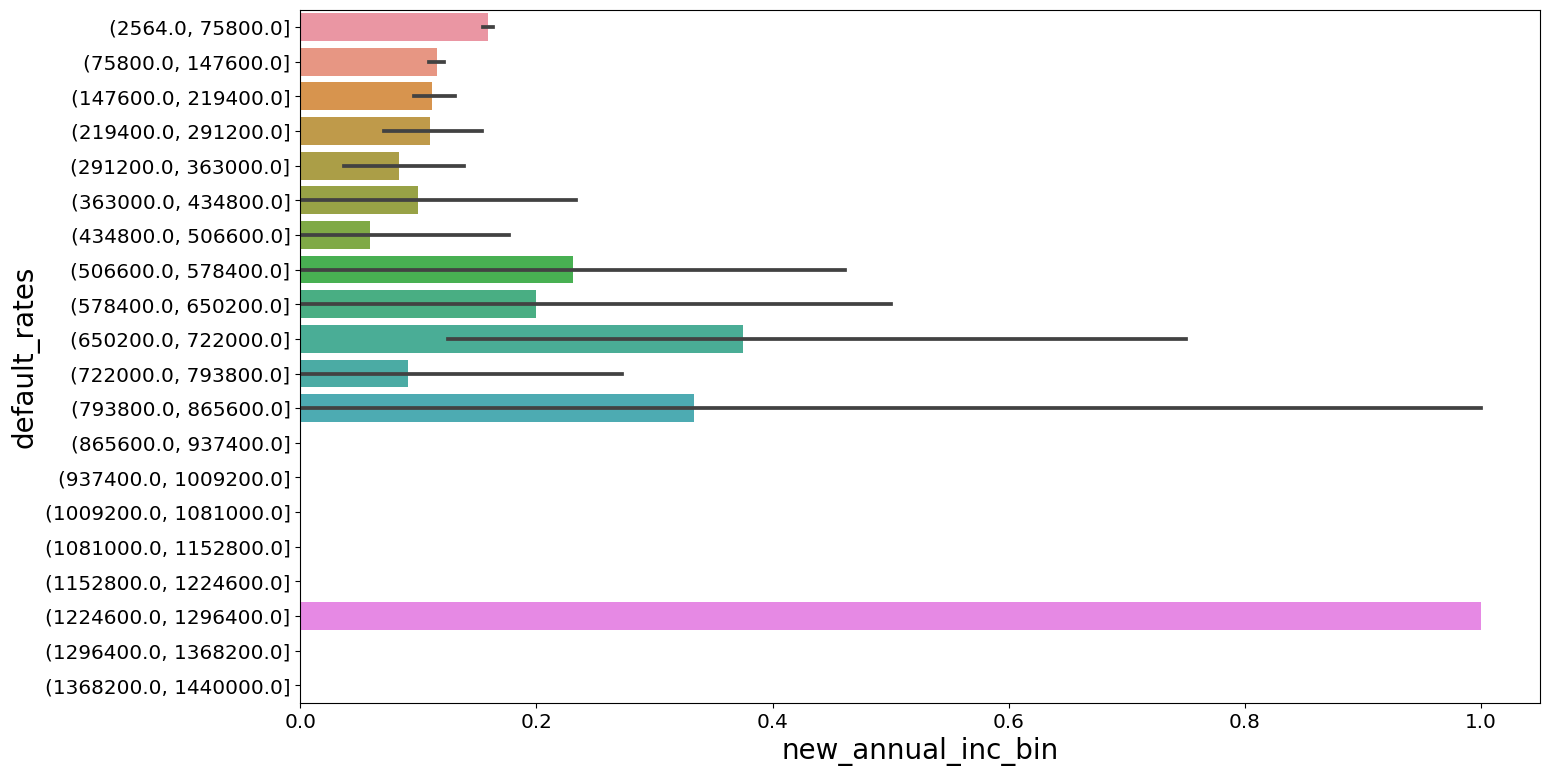

new_annual_inc_bin,values_count
"(3803.9, 13805.0]",304
"(13805.0, 23610.0]",1464
"(23610.0, 33415.0]",3821
"(33415.0, 43220.0]",5630
"(43220.0, 53025.0]",5577
"(53025.0, 62830.0]",4941
"(62830.0, 72635.0]",4096
"(72635.0, 82440.0]",3184
"(82440.0, 92245.0]",2361
"(92245.0, 102050.0]",1922


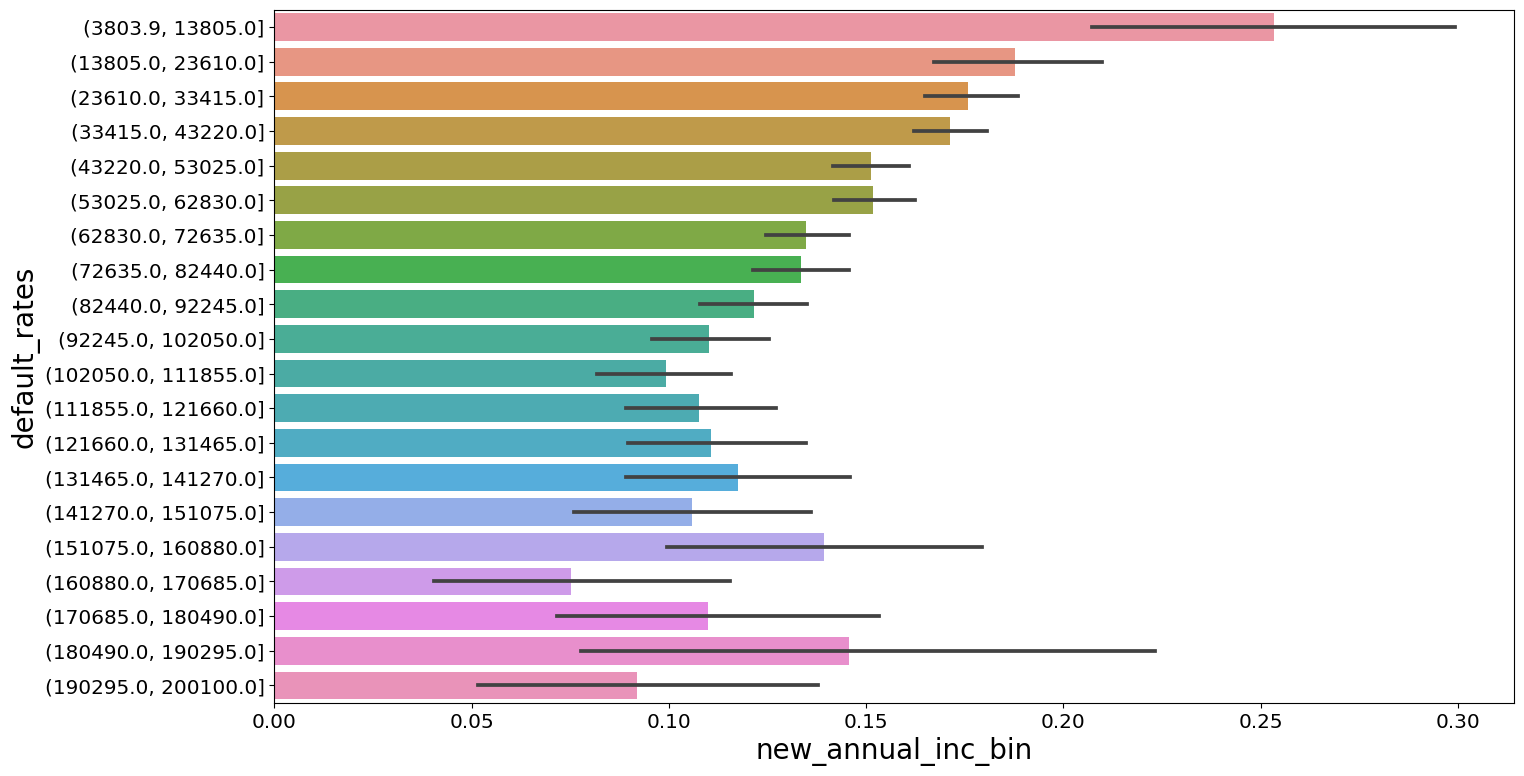

In [600]:
# remove outliers annual income first attempt
df['new_annual_inc'] = df[df['annual_inc'] <1503000]['annual_inc']
df['new_annual_inc_bin'] = pd.cut(np.array(df['new_annual_inc']), bins=20)
display(pd.DataFrame(df.groupby('new_annual_inc_bin')['new_annual_inc_bin'].count().reset_index(name = 'values_count')).style.hide())
defaulters_bar_plot('new_annual_inc_bin', df)

# remove outliers annual income second attempt
df['new_annual_inc'] = df[df['annual_inc'] <200350]['annual_inc']
df['new_annual_inc_bin'] = pd.cut(np.array(df['new_annual_inc']), bins=20)
display(pd.DataFrame(df.groupby('new_annual_inc_bin')['new_annual_inc_bin'].count().reset_index(name = 'values_count')).style.hide())
defaulters_bar_plot('new_annual_inc_bin', df)


list of most frequent defaulters' single values

In [601]:
# define function
def defaulters_pivot_top_num (list_cols, scale):

    for col_ in list_cols:

        pivottable_ = create_pivot(col_)

        pivottable_.drop(index=pivottable_[pivottable_['total_count']<scale].index, inplace=True)
        pivottable_.sort_values(by='default rates', ascending=False, inplace=True)
        new_df = pivottable_.head(20)
        
        sns.barplot(new_df, y='default rates', x=col_, order=new_df.sort_values('default rates',ascending=False)[col_])
        plt.xlabel(col_, fontsize=20)
        plt.ylabel('default rates',fontsize=20)
        display(pd.DataFrame(new_df.groupby(col_).sum()).sort_values(by='default rates', ascending=False))
        plt.show()

,Charged Off,Fully Paid,total_count,default rates
funded_amnt,,,,
7750,26.0,44.0,70.0,37.142857
15250,18.0,43.0,61.0,29.508197
21600,12.0,34.0,46.0,26.086957
35000,126.0,373.0,499.0,25.250501
15600,13.0,39.0,52.0,25.000000
19200,11.0,34.0,45.0,24.444444
3250,15.0,47.0,62.0,24.193548
13750,11.0,37.0,48.0,22.916667
12600,9.0,33.0,42.0,21.428571


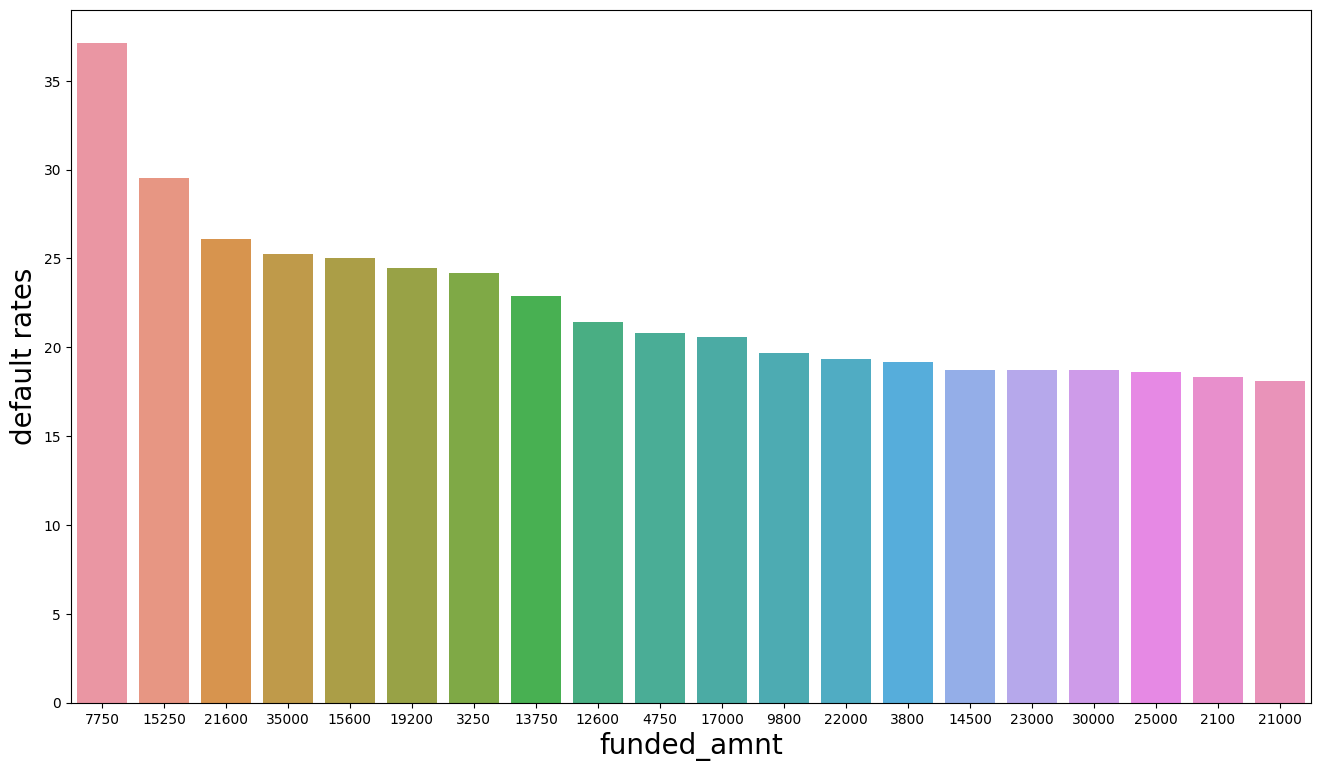

,Charged Off,Fully Paid,total_count,default rates
int_rate,,,,
20.89,29.0,27.0,56.0,51.785714
19.91,32.0,44.0,76.0,42.105263
20.30,31.0,46.0,77.0,40.259740
19.03,36.0,66.0,102.0,35.294118
17.49,59.0,114.0,173.0,34.104046
18.64,40.0,81.0,121.0,33.057851
20.62,15.0,31.0,46.0,32.608696
17.27,54.0,115.0,169.0,31.952663
20.25,22.0,47.0,69.0,31.884058


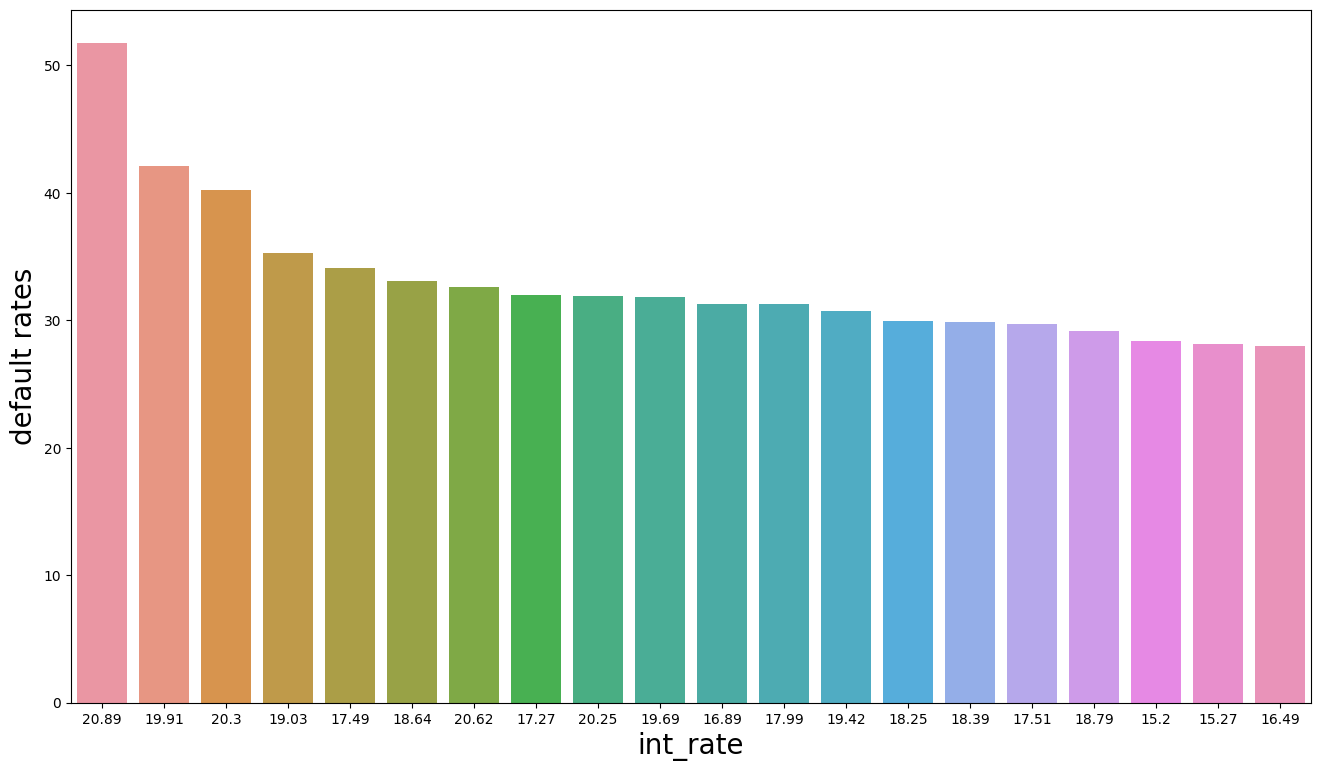

,Charged Off,Fully Paid,total_count,default rates
installment,,,,
339.31,7.0,35.0,42.0,16.666667
330.76,6.0,37.0,43.0,13.953488
373.33,3.0,37.0,40.0,7.500000
311.11,5.0,63.0,68.0,7.352941
317.72,3.0,38.0,41.0,7.317073
368.45,3.0,43.0,46.0,6.521739
186.61,2.0,39.0,41.0,4.878049
301.60,2.0,39.0,41.0,4.878049
372.12,2.0,43.0,45.0,4.444444


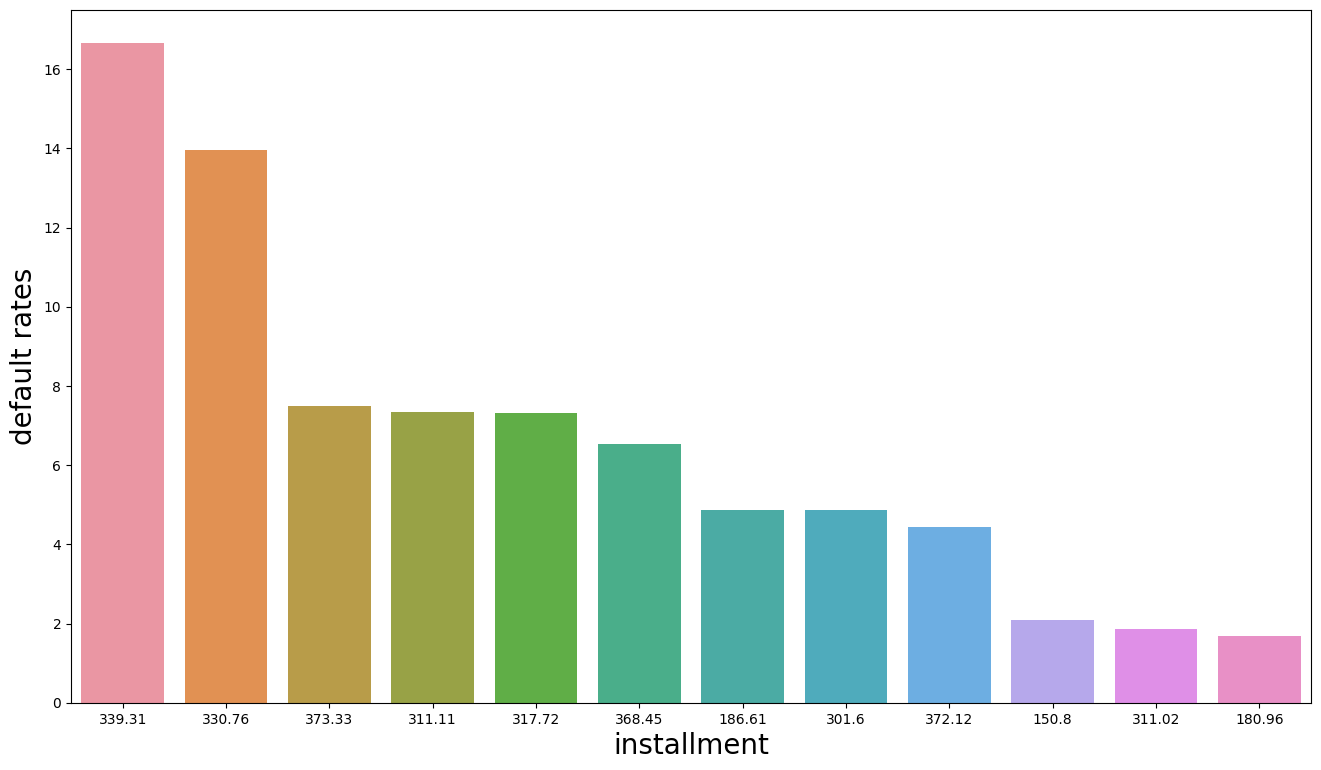

,Charged Off,Fully Paid,total_count,default rates
annual_inc,,,,
12000.0,24.0,63.0,87.0,27.586207
15000.0,17.0,48.0,65.0,26.153846
14400.0,24.0,70.0,94.0,25.531915
27600.0,15.0,45.0,60.0,25.000000
18000.0,34.0,103.0,137.0,24.817518
43200.0,21.0,69.0,90.0,23.333333
51600.0,10.0,33.0,43.0,23.255814
52800.0,12.0,40.0,52.0,23.076923
26000.0,24.0,81.0,105.0,22.857143


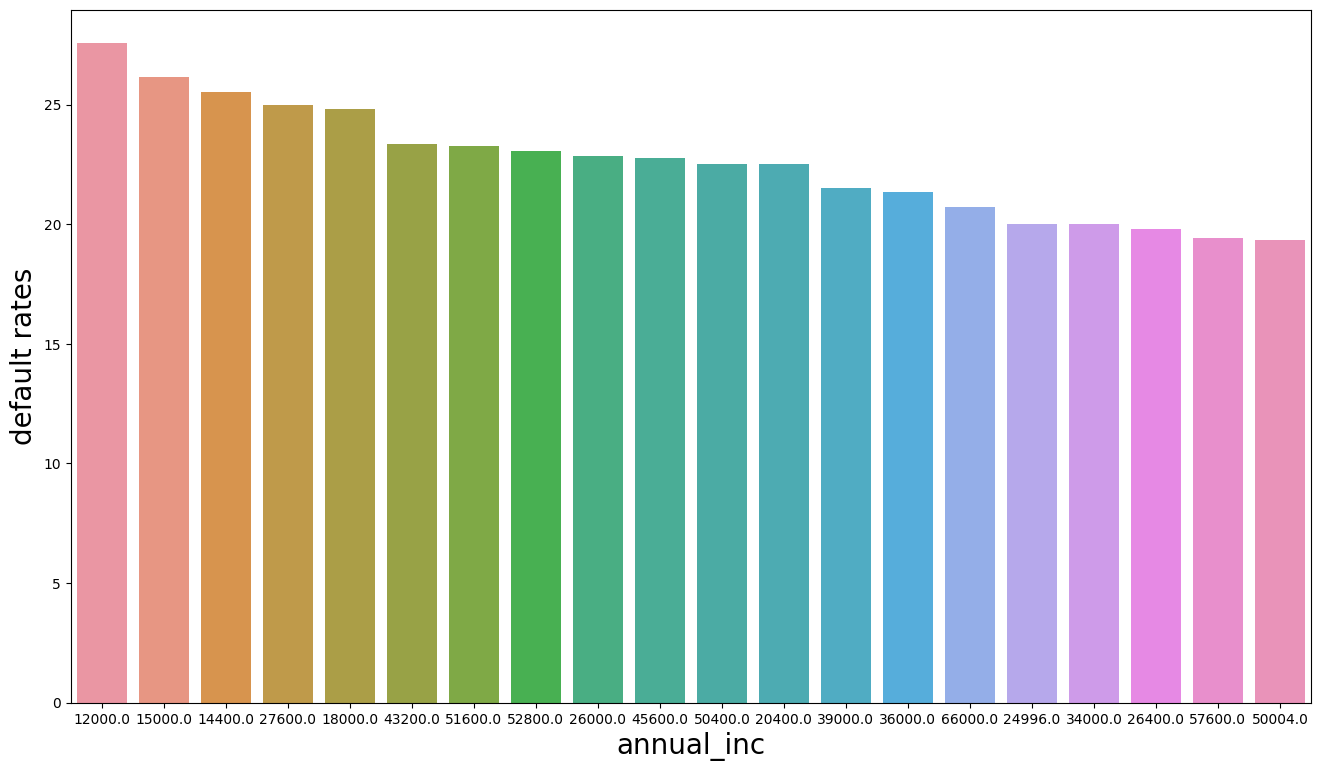

,Charged Off,Fully Paid,total_count,default rates
dti,,,,
18.0,13.0,32.0,45.0,28.888889
0.0,29.0,149.0,178.0,16.292135
12.0,5.0,41.0,46.0,10.869565


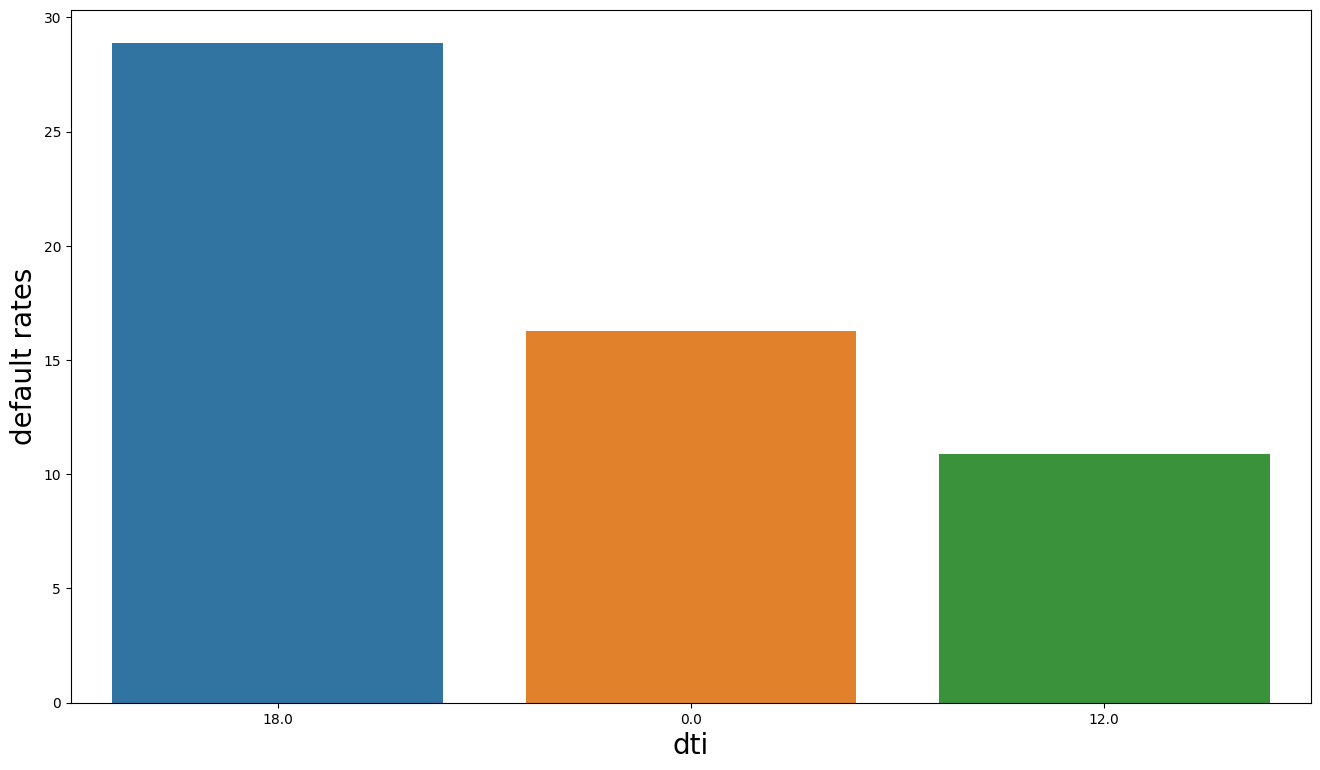

,Charged Off,Fully Paid,total_count,default rates
revol_util,,,,
63.7,15.0,28.0,43.0,34.883721
73.4,15.0,31.0,46.0,32.608696
80.6,14.0,30.0,44.0,31.818182
66.6,17.0,38.0,55.0,30.909091
80.3,13.0,30.0,43.0,30.232558
66.3,14.0,33.0,47.0,29.787234
94.6,12.0,29.0,41.0,29.268293
71.7,13.0,33.0,46.0,28.260870
81.6,12.0,31.0,43.0,27.906977


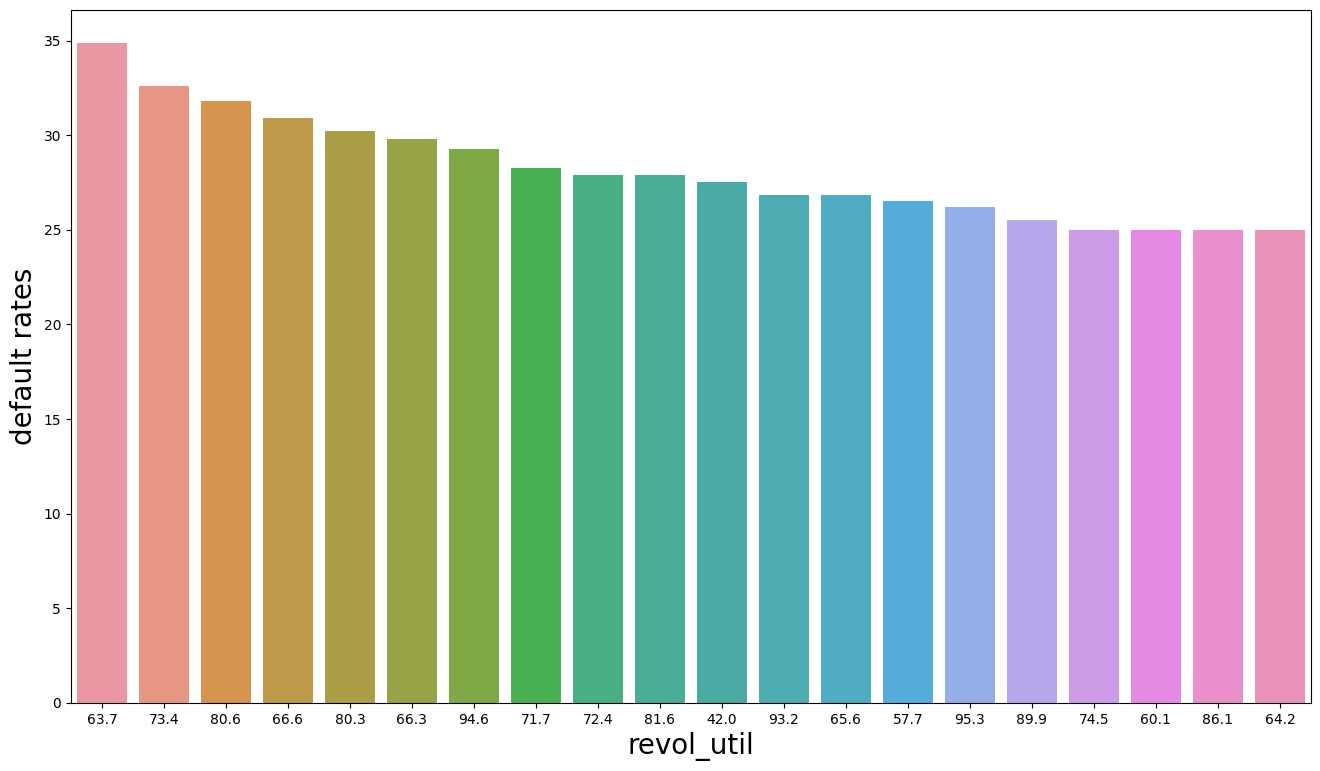

In [602]:
# execute function
defaulters_pivot_top_num(num_cols, 40)

Bivariate Analysis

create a dataset contains all unique combinations between sub attributes

In [603]:
# define function
from itertools import product
def self_comb(col1,col2):
    from itertools import product
    combination_ = pd.DataFrame((product(col1, col2)))
    # sort each row and append to unique_comb dataframe
    unique_comb = pd.concat([pd.DataFrame(np.reshape(sorted(list(combination_.iloc[x].values)),(1,2))) for x in range(len(combination_))])
    # remove duplicates
    unique_comb.drop_duplicates(inplace=True)
    unique_comb.reset_index(inplace=True)
    unique_comb.drop(columns=['index'], inplace=True)

    # deleted repeated row values accross column
    repeated_row_index = [x for x in range(len(unique_comb)) if len(list(unique_comb.iloc[x])) != len(set(unique_comb.iloc[x]))]
    unique_comb.drop(index=repeated_row_index, inplace=True)
    unique_comb.rename(columns={0:'index 1', 1:'index 2'}, inplace=True)
    return (unique_comb)

In [604]:
# create a dataset contains all unique combinations between sub attributes
cat_comb = self_comb(cat_cols, cat_cols)
display(cat_comb)

,index 1,index 2
1,grade,term
2,sub_grade,term
3,home_ownership,term
4,term,verification_status
5,purpose,term
6,addr_state,term
7,emp_length,term
9,grade,sub_grade
10,grade,home_ownership
11,grade,verification_status


In [605]:
# define pivot table initialization function
def create_pivot_bivar(index1, index2, scale):
    pivottable_ = pd.pivot_table(df, columns=['loan_status'], index=[index1, index2], values=['all_count'], aggfunc='sum')
    pivottable_ = pivottable_.droplevel(0, axis=1)
    pivottable_['total_count'] = pivottable_['Charged Off'] + pivottable_['Fully Paid']
    pivottable_['default rates'] = pivottable_['Charged Off']/pivottable_['total_count']*100
    pivottable_.reset_index(inplace=True)
    pivottable_ = pivottable_.rename_axis(None, axis=1)   
    pivottable_.fillna(0, inplace=True)    
    pivottable_.drop(index=pivottable_[pivottable_['total_count']<scale].index, inplace=True)

    pivottable_.insert(loc=0, column='attribute 1', value=index1)
    pivottable_.insert(loc=1, column='attribute 2', value=index2)
    
    pivottable_[index1] = index1 + ': ' + pivottable_[index1]  
    pivottable_[index2] = index2 + ': ' + pivottable_[index2] 

    # pivottable_.rename(columns={index1:'sub attribute 1', index2:'sub attribute 2'}, inplace=True)
    return pivottable_

In [606]:
# define function
def defaulters_pivot_bivar (list_pairs, scale):

# initialize variables
    new_df = pd.DataFrame()

    # anlysis
    for index, row in list_pairs.iterrows():
        pivottable_ = create_pivot_bivar(row[0], row[1], scale)
        pivottable_.rename(columns={row[0]:'sub attribute 1', row[1]:'sub attribute 2'}, inplace=True)
        new_df = pd.concat([new_df, pivottable_], axis=0)
    new_df.sort_values(by='default rates', ascending=False, inplace=True)
    new_df.reset_index(inplace=True)
    new_df.drop(columns='index', inplace=True)

    return new_df

In [607]:
# display top attribute pairs with highest percentage of defaulters
display(defaulters_pivot_bivar(cat_comb, 100).iloc[:,2:].head(20).style.hide())


sub attribute 1,sub attribute 2,Charged Off,Fully Paid,total_count,default rates
grade: F,sub_grade: F5,54.000000,59.000000,113.000000,47.787611
sub_grade: F4,term: 60 months,47.000000,66.000000,113.000000,41.592920
purpose: small_business,term: 60 months,206.000000,309.000000,515.000000,40.000000
emp_length: 10+ years,grade: F,94.000000,153.000000,247.000000,38.056680
addr_state: FL,purpose: small_business,50.000000,88.000000,138.000000,36.231884
home_ownership: RENT,sub_grade: F2,38.000000,67.000000,105.000000,36.190476
addr_state: FL,grade: E,65.000000,116.000000,181.000000,35.911602
grade: G,home_ownership: RENT,48.000000,86.000000,134.000000,35.820896
grade: F,purpose: debt_consolidation,199.000000,357.000000,556.000000,35.791367
grade: E,purpose: small_business,66.000000,122.000000,188.000000,35.106383


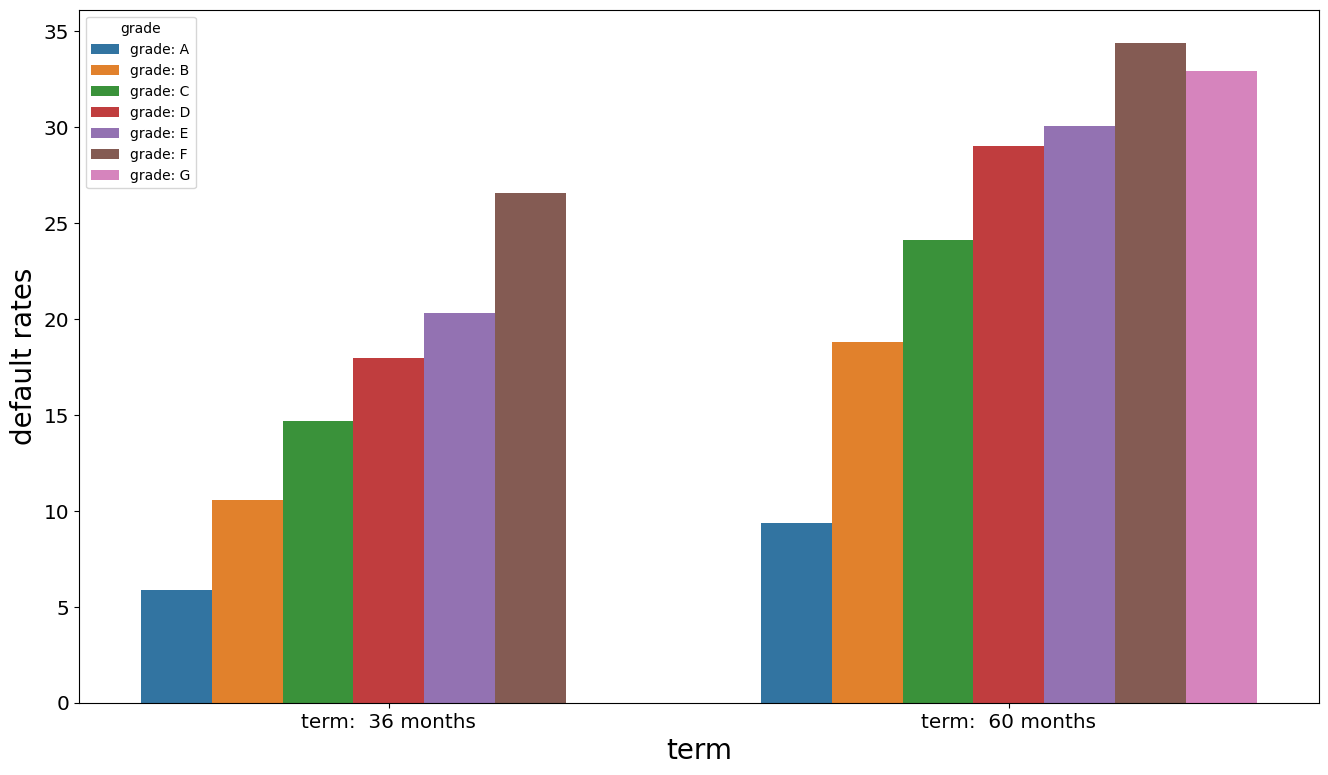

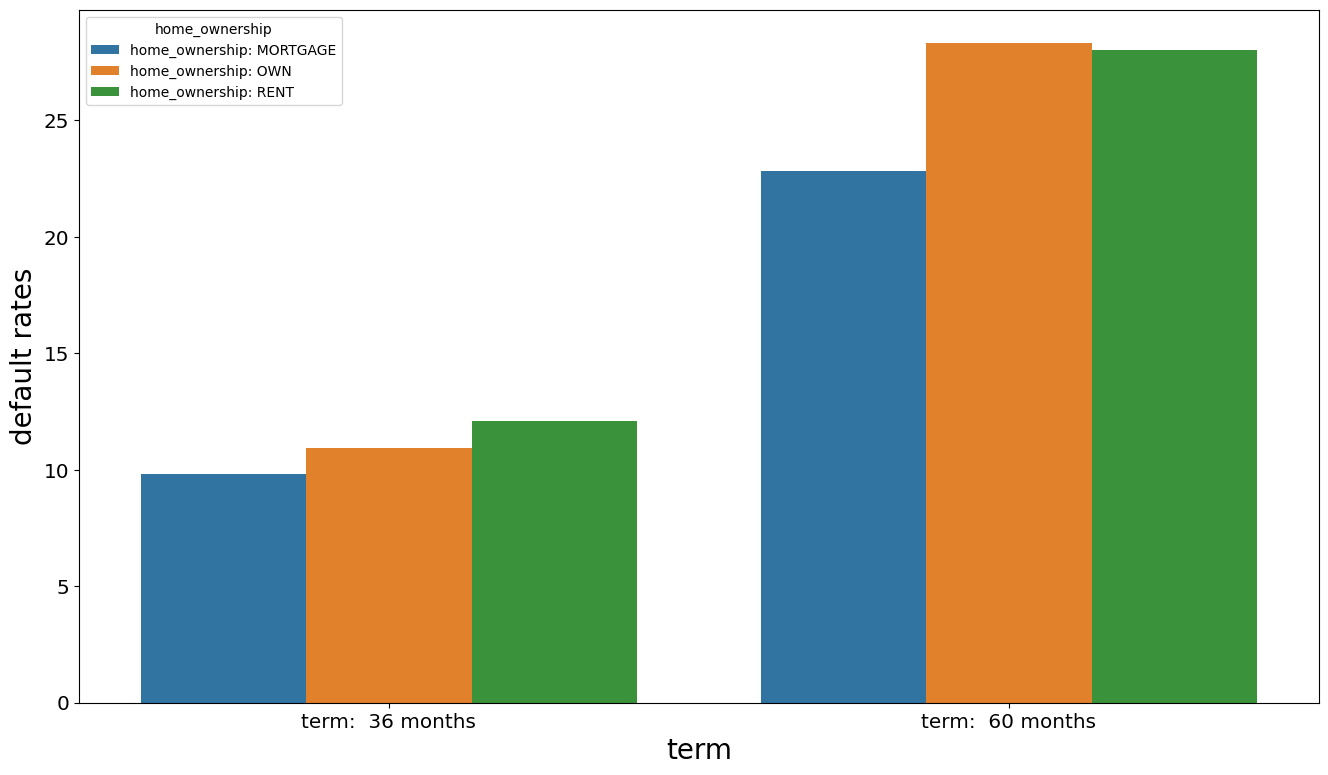

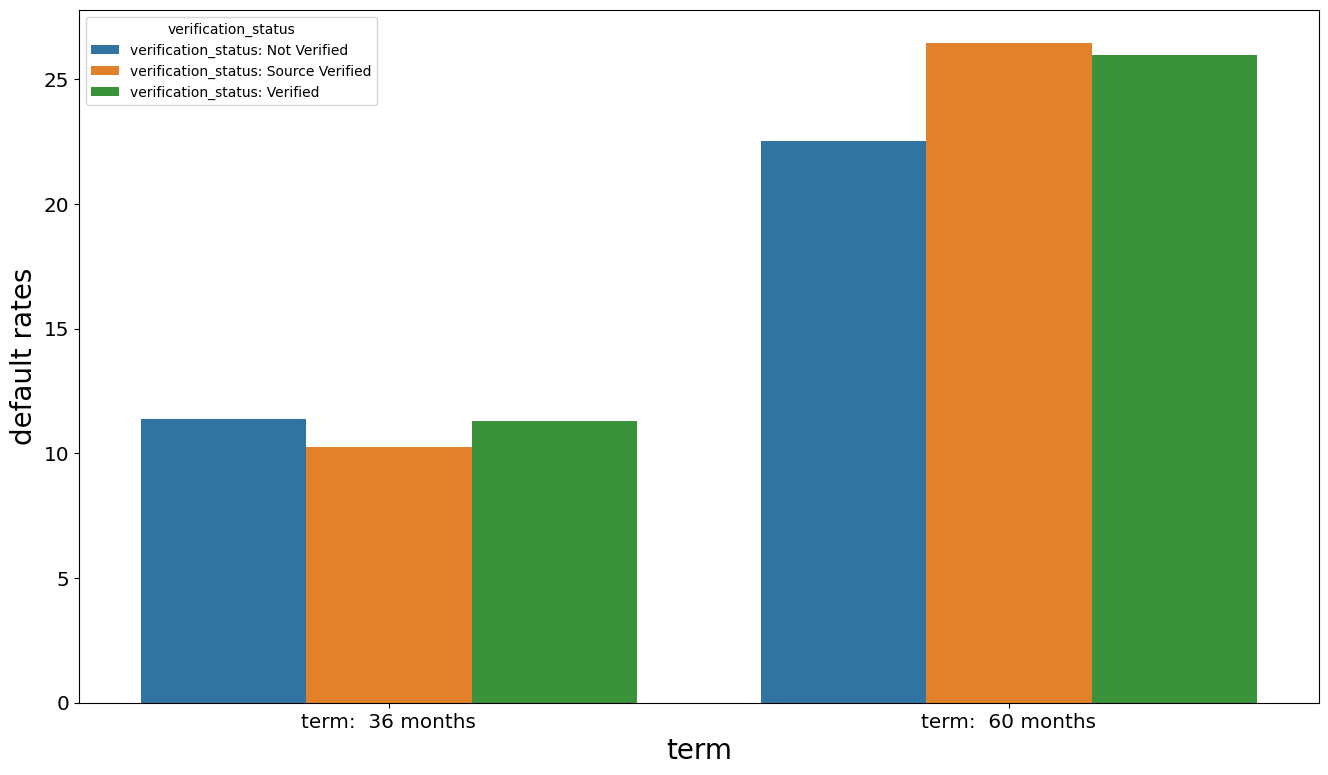

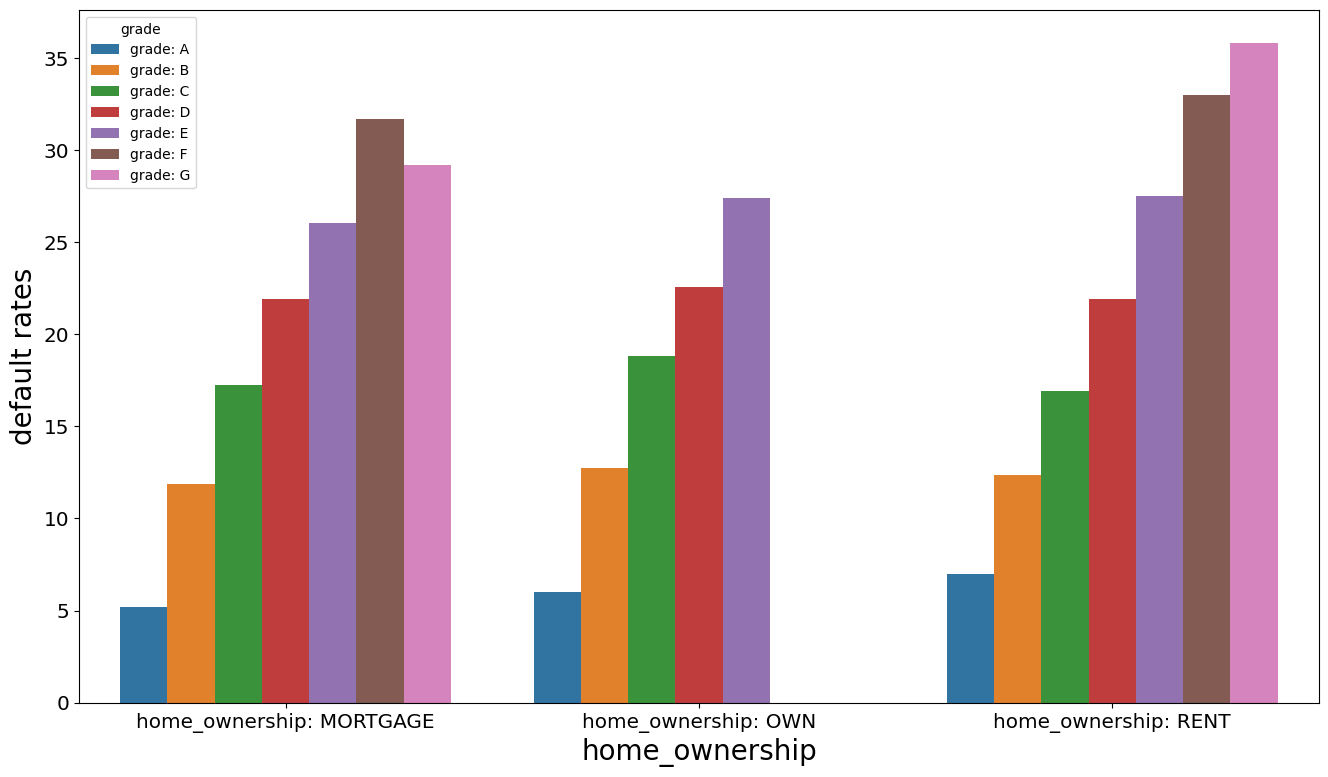

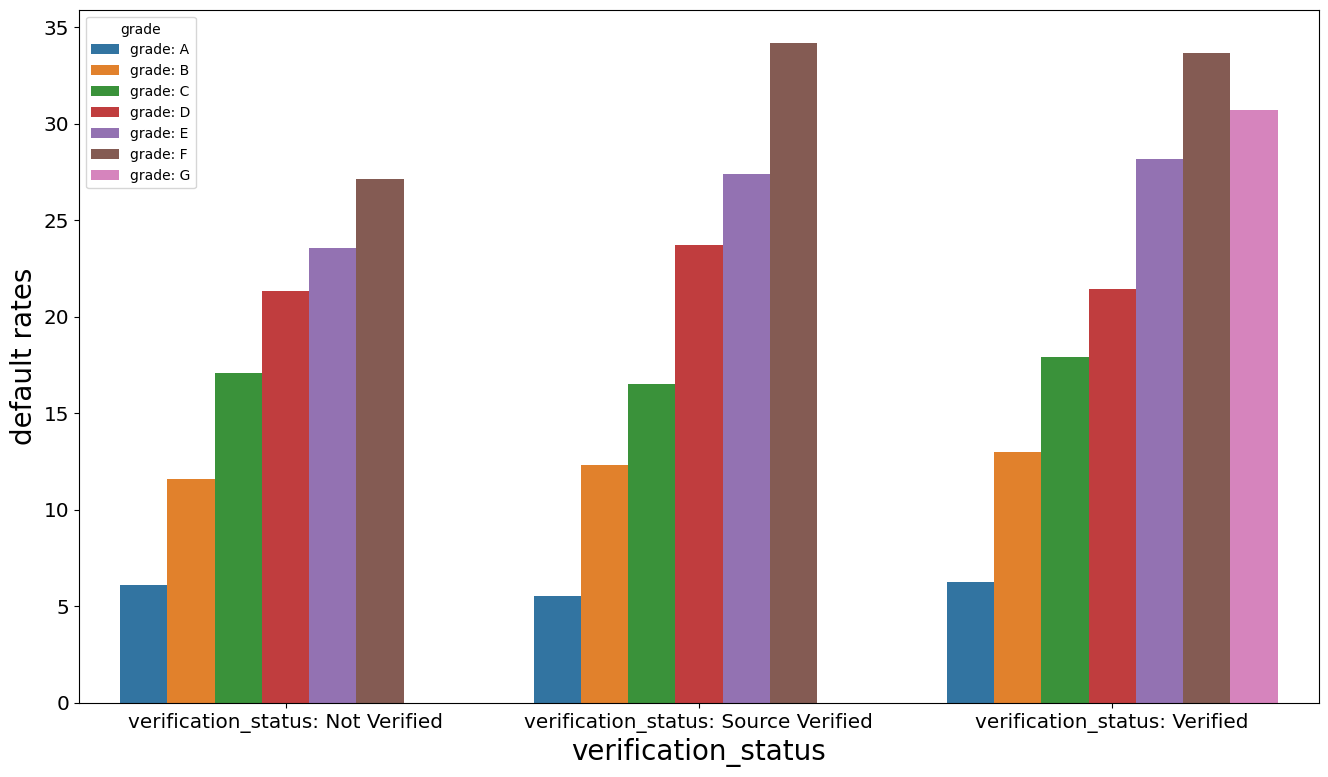

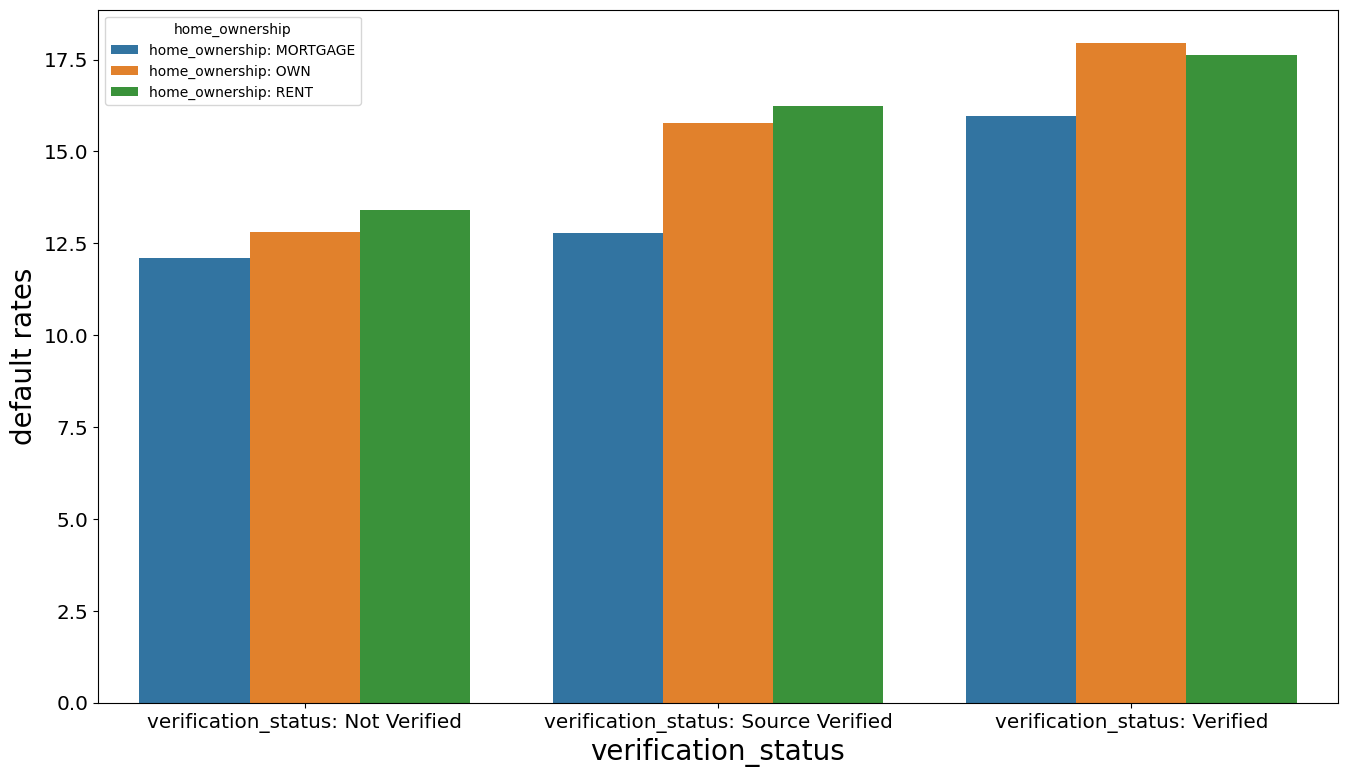

In [608]:
# display the grouped bar plot for further visualizing bivarate analysis data 
# only show data with less then 10 unique values
for index, row in cat_comb.iterrows():
    pivottable_ = create_pivot_bivar(row[0], row[1], 100)
    if (df[row[0]].nunique()<=10) & (df[row[1]].nunique()<=10):
        if df[row[0]].nunique()<df[row[1]].nunique():
            sns.barplot(x=row[0], y='default rates', hue=row[1], data=pivottable_)
            plt.xlabel(row[0], fontsize=20)
        else:
            sns.barplot(x=row[1], y='default rates', hue=row[0], data=pivottable_)
            plt.xlabel(row[1], fontsize=20)
        plt.ylabel('default rates',fontsize=20)
        plt.yticks(fontsize='x-large')
        plt.xticks(fontsize='x-large') 
        plt.show()
    continue